<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=1, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=70, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=70, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex999_channel_seeds_PGM1_v2_debug.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW100Seed_22channels.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


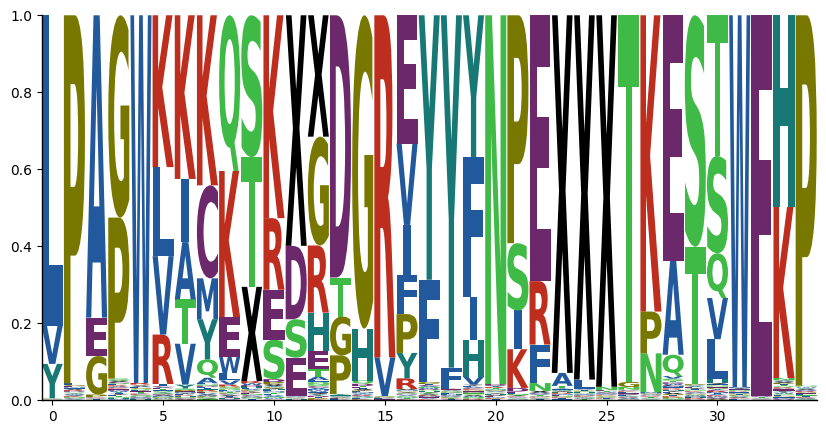

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,500, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) #- beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10



Epoch 1/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)

Epoch 1/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00,  8.75samples/s]


Epoch 1/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00,  8.75samples/s, loss=488.6829528808594]


Epoch 1/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82samples/s, loss=488.6829528808594]


Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82samples/s, loss=509.38739013671875]


Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.78samples/s, loss=509.38739013671875]


Epoch 2/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 2/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 2/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=494.5714111328125]


Epoch 2/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=494.5714111328125]


Epoch 2/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=515.6055297851562]


Epoch 2/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=515.6055297851562]


Epoch 3/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 3/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.01samples/s]


Epoch 3/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.01samples/s, loss=492.9627990722656]


Epoch 3/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89samples/s, loss=492.9627990722656]


Epoch 3/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89samples/s, loss=515.5546264648438]


Epoch 3/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.74samples/s, loss=515.5546264648438]


Epoch 4/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 4/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.02samples/s]


Epoch 4/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.02samples/s, loss=495.9786071777344]


Epoch 4/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87samples/s, loss=495.9786071777344]


Epoch 4/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87samples/s, loss=522.651611328125]


Epoch 4/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73samples/s, loss=522.651611328125]


Epoch 5/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 5/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 13.97samples/s]


Epoch 5/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 13.97samples/s, loss=480.676025390625]


Epoch 5/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95samples/s, loss=480.676025390625]


Epoch 5/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95samples/s, loss=514.1441040039062]


Epoch 5/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86samples/s, loss=514.1441040039062]


Epoch 6/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 6/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 13.69samples/s]


Epoch 6/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 13.69samples/s, loss=486.00946044921875]


Epoch 6/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91samples/s, loss=486.00946044921875]


Epoch 6/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91samples/s, loss=516.8103637695312]


Epoch 6/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.80samples/s, loss=516.8103637695312]


Epoch 7/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 7/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.00samples/s]


Epoch 7/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.00samples/s, loss=487.97967529296875]


Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=487.97967529296875]


Epoch 7/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=517.6989135742188]


Epoch 7/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.71samples/s, loss=517.6989135742188]


Epoch 8/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 8/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 8/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.09samples/s, loss=487.138427734375]


Epoch 8/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.02samples/s, loss=487.138427734375]


Epoch 8/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.02samples/s, loss=515.2169189453125]


Epoch 8/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=515.2169189453125]


Epoch 9/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]


Epoch 9/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 13.99samples/s]


Epoch 9/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 13.99samples/s, loss=482.4271240234375]


Epoch 9/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.81samples/s, loss=482.4271240234375]


Epoch 9/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.81samples/s, loss=513.1624755859375]


Epoch 9/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.72samples/s, loss=513.1624755859375]


Epoch 10/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 10/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 10/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=509.70819091796875]


Epoch 10/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.94samples/s, loss=509.70819091796875]


Epoch 10/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.94samples/s, loss=508.900390625]


Epoch 10/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.80samples/s, loss=508.900390625]


Epoch 11/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 11/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.06samples/s]


Epoch 11/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.06samples/s, loss=467.8028564453125]


Epoch 11/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.03samples/s, loss=467.8028564453125]


Epoch 11/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.03samples/s, loss=508.2695617675781]


Epoch 11/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=508.2695617675781]


Epoch 12/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 12/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.08samples/s]


Epoch 12/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.08samples/s, loss=487.3132019042969]


Epoch 12/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01samples/s, loss=487.3132019042969]


Epoch 12/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01samples/s, loss=516.7969970703125]


Epoch 12/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=516.7969970703125]


Epoch 13/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 13/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 13/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.09samples/s, loss=472.5518493652344]


Epoch 13/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=472.5518493652344]


Epoch 13/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=513.0738525390625]


Epoch 13/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=513.0738525390625]


Epoch 14/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 14/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 14/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.09samples/s, loss=474.9631652832031]


Epoch 14/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=474.9631652832031]


Epoch 14/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=510.860107421875]


Epoch 14/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=510.860107421875]


Epoch 15/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 15/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 15/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.10samples/s, loss=475.3502197265625]


Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=475.3502197265625]


Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=508.3808288574219]


Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=508.3808288574219]


Epoch 16/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 16/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.04samples/s]


Epoch 16/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.04samples/s, loss=480.06097412109375]


Epoch 16/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=480.06097412109375]


Epoch 16/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=506.83782958984375]


Epoch 16/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83samples/s, loss=506.83782958984375]


Epoch 17/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 17/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 13.95samples/s]


Epoch 17/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.95samples/s, loss=463.21209716796875]


Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=463.21209716796875]


Epoch 17/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=509.3192443847656]


Epoch 17/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=509.3192443847656]


Epoch 18/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 18/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.22samples/s]


Epoch 18/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.22samples/s, loss=470.7630615234375]


Epoch 18/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=470.7630615234375]


Epoch 18/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=507.9088134765625]


Epoch 18/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=507.9088134765625]


Epoch 19/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 19/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 19/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.25samples/s, loss=471.3065185546875]


Epoch 19/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=471.3065185546875]


Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=505.53070068359375]


Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=505.53070068359375]


Epoch 20/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 20/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.22samples/s]


Epoch 20/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.22samples/s, loss=473.0694580078125]


Epoch 20/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=473.0694580078125]


Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=505.77606201171875]


Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=505.77606201171875]


Epoch 21/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 21/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.24samples/s]


Epoch 21/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.24samples/s, loss=478.66253662109375]


Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=478.66253662109375]


Epoch 21/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=506.5150146484375]


Epoch 21/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=506.5150146484375]


Epoch 22/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 22/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 22/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.25samples/s, loss=477.13134765625]


Epoch 22/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=477.13134765625]


Epoch 22/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=503.0608215332031]


Epoch 22/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=503.0608215332031]


Epoch 23/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 23/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 13.88samples/s]


Epoch 23/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 13.88samples/s, loss=466.3661193847656]


Epoch 23/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=466.3661193847656]


Epoch 23/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=518.8373413085938]


Epoch 23/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=518.8373413085938]


Epoch 24/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 24/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.26samples/s]


Epoch 24/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=484.34991455078125]


Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=484.34991455078125]


Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=505.80242919921875]


Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=505.80242919921875]


Epoch 25/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 25/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.27samples/s]


Epoch 25/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.27samples/s, loss=462.56976318359375]


Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=462.56976318359375]


Epoch 25/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=505.66796875]


Epoch 25/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=505.66796875]


Epoch 26/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 26/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.24samples/s]


Epoch 26/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.24samples/s, loss=484.0369873046875]


Epoch 26/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=484.0369873046875]


Epoch 26/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=506.01708984375]


Epoch 26/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=506.01708984375]


Epoch 27/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 27/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.20samples/s]


Epoch 27/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.20samples/s, loss=490.439697265625]


Epoch 27/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=490.439697265625]


Epoch 27/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=500.5910339355469]


Epoch 27/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=500.5910339355469]


Epoch 28/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 28/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.26samples/s]


Epoch 28/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=479.05950927734375]


Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=479.05950927734375]


Epoch 28/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=504.3630065917969]


Epoch 28/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01samples/s, loss=504.3630065917969]


Epoch 29/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 29/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.23samples/s]


Epoch 29/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.23samples/s, loss=478.0638427734375]


Epoch 29/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=478.0638427734375]


Epoch 29/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=500.5066223144531]


Epoch 29/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=500.5066223144531]


Epoch 30/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 30/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 30/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.21samples/s, loss=471.9872131347656]


Epoch 30/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=471.9872131347656]


Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=503.77667236328125]


Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=503.77667236328125]


Epoch 31/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 31/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.23samples/s]


Epoch 31/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.23samples/s, loss=487.1396484375]


Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=487.1396484375]


Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=502.17535400390625]


Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=502.17535400390625]


Epoch 32/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 32/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.26samples/s]


Epoch 32/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.26samples/s, loss=476.5614013671875]


Epoch 32/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=476.5614013671875]


Epoch 32/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=502.01416015625]


Epoch 32/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02samples/s, loss=502.01416015625]


Epoch 33/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 33/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.28samples/s]


Epoch 33/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.28samples/s, loss=473.8092346191406]


Epoch 33/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=473.8092346191406]


Epoch 33/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=505.1636047363281]


Epoch 33/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=505.1636047363281]


Epoch 34/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 34/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.29samples/s]


Epoch 34/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.29samples/s, loss=478.1102600097656]


Epoch 34/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=478.1102600097656]


Epoch 34/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=500.343505859375]


Epoch 34/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=500.343505859375]


Epoch 35/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 35/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.27samples/s]


Epoch 35/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.27samples/s, loss=468.1517333984375]


Epoch 35/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=468.1517333984375]


Epoch 35/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=500.8410949707031]


Epoch 35/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=500.8410949707031]


Epoch 36/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 36/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.20samples/s]


Epoch 36/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.20samples/s, loss=478.88751220703125]


Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=478.88751220703125]


Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=497.53338623046875]


Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=497.53338623046875]


Epoch 37/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 37/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.20samples/s]


Epoch 37/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.20samples/s, loss=489.236572265625]


Epoch 37/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=489.236572265625]


Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=496.50372314453125]


Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=496.50372314453125]


Epoch 38/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 38/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 13.72samples/s]


Epoch 38/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 13.72samples/s, loss=471.7091064453125]


Epoch 38/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=471.7091064453125]


Epoch 38/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=493.9337463378906]


Epoch 38/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83samples/s, loss=493.9337463378906]


Epoch 39/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 39/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 39/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=470.87127685546875]


Epoch 39/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=470.87127685546875]


Epoch 39/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=494.5138244628906]


Epoch 39/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=494.5138244628906]


Epoch 40/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 40/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.27samples/s]


Epoch 40/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.27samples/s, loss=480.46307373046875]


Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=480.46307373046875]


Epoch 40/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=489.96337890625]


Epoch 40/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=489.96337890625]


Epoch 41/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 41/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.24samples/s]


Epoch 41/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.24samples/s, loss=475.20782470703125]


Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=475.20782470703125]


Epoch 41/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=489.9249267578125]


Epoch 41/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=489.9249267578125]


Epoch 42/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 42/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 42/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.25samples/s, loss=481.5030822753906]


Epoch 42/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=481.5030822753906]


Epoch 42/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=490.9560241699219]


Epoch 42/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=490.9560241699219]


Epoch 43/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 43/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.26samples/s]


Epoch 43/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=499.45513916015625]


Epoch 43/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=499.45513916015625]


Epoch 43/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=493.8685302734375]


Epoch 43/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=493.8685302734375]


Epoch 44/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 44/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 44/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=475.64886474609375]


Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=475.64886474609375]


Epoch 44/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=486.8324890136719]


Epoch 44/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=486.8324890136719]


Epoch 45/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 45/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 45/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=468.48016357421875]


Epoch 45/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=468.48016357421875]


Epoch 45/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=499.2810974121094]


Epoch 45/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=499.2810974121094]


Epoch 46/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 46/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 46/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.25samples/s, loss=470.4767761230469]


Epoch 46/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=470.4767761230469]


Epoch 46/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=494.4331970214844]


Epoch 46/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=494.4331970214844]


Epoch 47/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 47/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 47/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.21samples/s, loss=484.65887451171875]


Epoch 47/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=484.65887451171875]


Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=491.9461364746094]


Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=491.9461364746094]


Epoch 48/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 48/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.22samples/s]


Epoch 48/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.22samples/s, loss=482.1820068359375]


Epoch 48/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=482.1820068359375]


Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=489.67340087890625]


Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=489.67340087890625]


Epoch 49/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 49/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.23samples/s]


Epoch 49/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.23samples/s, loss=487.3563232421875]


Epoch 49/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=487.3563232421875]


Epoch 49/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=482.2762756347656]


Epoch 49/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=482.2762756347656]


Epoch 50/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 50/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 50/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.14samples/s, loss=471.9132080078125]


Epoch 50/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=471.9132080078125]


Epoch 50/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=484.468505859375]


Epoch 50/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=484.468505859375]


Epoch 51/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 51/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 51/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=506.27081298828125]


Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=506.27081298828125]


Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=481.55413818359375]


Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=481.55413818359375]


Epoch 52/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 52/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 52/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=471.0103759765625]


Epoch 52/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=471.0103759765625]


Epoch 52/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=481.6861572265625]


Epoch 52/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=481.6861572265625]


Epoch 53/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 53/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 53/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.19samples/s, loss=476.3091125488281]


Epoch 53/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=476.3091125488281]


Epoch 53/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=480.3876953125]


Epoch 53/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=480.3876953125]


Epoch 54/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 54/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.23samples/s]


Epoch 54/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.23samples/s, loss=472.4674072265625]


Epoch 54/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=472.4674072265625]


Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=489.24176025390625]


Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02samples/s, loss=489.24176025390625]


Epoch 55/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 55/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.24samples/s]


Epoch 55/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.24samples/s, loss=480.0173645019531]


Epoch 55/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=480.0173645019531]


Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=488.98773193359375]


Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=488.98773193359375]


Epoch 56/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 56/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 56/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.21samples/s, loss=482.10260009765625]


Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=482.10260009765625]


Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=483.4111328125]


Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02samples/s, loss=483.4111328125]


Epoch 57/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 57/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 57/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.19samples/s, loss=483.96795654296875]


Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=483.96795654296875]


Epoch 57/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=500.8358154296875]


Epoch 57/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=500.8358154296875]


Epoch 58/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 58/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 58/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.18samples/s, loss=474.30145263671875]


Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=474.30145263671875]


Epoch 58/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=488.8735046386719]


Epoch 58/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=488.8735046386719]


Epoch 59/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 59/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 59/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.21samples/s, loss=473.5053405761719]


Epoch 59/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=473.5053405761719]


Epoch 59/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=480.2367248535156]


Epoch 59/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01samples/s, loss=480.2367248535156]


Epoch 60/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 60/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.20samples/s]


Epoch 60/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.20samples/s, loss=486.66851806640625]


Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=486.66851806640625]


Epoch 60/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=483.1107177734375]


Epoch 60/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=483.1107177734375]


Epoch 61/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 61/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 61/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.18samples/s, loss=488.1903076171875]


Epoch 61/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=488.1903076171875]


Epoch 61/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=490.1627502441406]


Epoch 61/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=490.1627502441406]


Epoch 62/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 62/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 62/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=481.3611145019531]


Epoch 62/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=481.3611145019531]


Epoch 62/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=489.5151062011719]


Epoch 62/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01samples/s, loss=489.5151062011719]


Epoch 63/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 63/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 63/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.12samples/s, loss=465.310546875]


Epoch 63/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=465.310546875]


Epoch 63/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=487.48779296875]


Epoch 63/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=487.48779296875]


Epoch 64/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 64/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 64/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=481.8182373046875]


Epoch 64/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95samples/s, loss=481.8182373046875]


Epoch 64/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95samples/s, loss=488.361572265625]


Epoch 64/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.87samples/s, loss=488.361572265625]


Epoch 65/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 65/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 65/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=457.4851989746094]


Epoch 65/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=457.4851989746094]


Epoch 65/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=491.3338928222656]


Epoch 65/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.82samples/s, loss=491.3338928222656]


Epoch 66/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 66/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 66/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.17samples/s, loss=468.345703125]


Epoch 66/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=468.345703125]


Epoch 66/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=484.654052734375]


Epoch 66/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=484.654052734375]


Epoch 67/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 67/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 67/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.19samples/s, loss=461.7761535644531]


Epoch 67/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=461.7761535644531]


Epoch 67/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=484.9401550292969]


Epoch 67/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=484.9401550292969]


Epoch 68/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 68/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 68/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.13samples/s, loss=462.244384765625]


Epoch 68/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=462.244384765625]


Epoch 68/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=475.9036560058594]


Epoch 68/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=475.9036560058594]


Epoch 69/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 69/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 69/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.19samples/s, loss=481.64208984375]


Epoch 69/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=481.64208984375]


Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=489.91595458984375]


Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=489.91595458984375]


Epoch 70/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 70/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.08samples/s]


Epoch 70/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.08samples/s, loss=476.1385498046875]


Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01samples/s, loss=476.1385498046875]


Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01samples/s, loss=484.3622131347656]


Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=484.3622131347656]


Epoch 71/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 71/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 13.98samples/s]


Epoch 71/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 13.98samples/s, loss=481.824462890625]


Epoch 71/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.82samples/s, loss=481.824462890625]


Epoch 71/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.82samples/s, loss=483.517822265625]


Epoch 71/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.77samples/s, loss=483.517822265625]


Epoch 72/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 72/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 72/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.15samples/s, loss=479.5437316894531]


Epoch 72/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=479.5437316894531]


Epoch 72/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=479.8349304199219]


Epoch 72/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=479.8349304199219]


Epoch 73/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 73/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 73/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.17samples/s, loss=469.2424621582031]


Epoch 73/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=469.2424621582031]


Epoch 73/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=483.880859375]


Epoch 73/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=483.880859375]


Epoch 74/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 74/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 74/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=473.7563171386719]


Epoch 74/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=473.7563171386719]


Epoch 74/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=490.2928771972656]


Epoch 74/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=490.2928771972656]


Epoch 75/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 75/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 75/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=476.82330322265625]


Epoch 75/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=476.82330322265625]


Epoch 75/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=485.072509765625]


Epoch 75/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=485.072509765625]


Epoch 76/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 76/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 76/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.15samples/s, loss=475.6300048828125]


Epoch 76/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=475.6300048828125]


Epoch 76/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=489.4952392578125]


Epoch 76/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=489.4952392578125]


Epoch 77/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 77/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 77/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=475.2965087890625]


Epoch 77/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98samples/s, loss=475.2965087890625]


Epoch 77/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98samples/s, loss=483.4770202636719]


Epoch 77/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=483.4770202636719]


Epoch 78/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 78/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 78/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=483.4537658691406]


Epoch 78/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=483.4537658691406]


Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=474.46759033203125]


Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=474.46759033203125]


Epoch 79/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 79/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 79/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.18samples/s, loss=470.3480224609375]


Epoch 79/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=470.3480224609375]


Epoch 79/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=475.6351318359375]


Epoch 79/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=475.6351318359375]


Epoch 80/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 80/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 80/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.12samples/s, loss=496.274658203125]


Epoch 80/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=496.274658203125]


Epoch 80/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=487.54736328125]


Epoch 80/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=487.54736328125]


Epoch 81/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 81/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 81/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.13samples/s, loss=470.3326416015625]


Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.02samples/s, loss=470.3326416015625]


Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.02samples/s, loss=487.0225830078125]


Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83samples/s, loss=487.0225830078125]


Epoch 82/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 82/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 82/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.10samples/s, loss=491.2490539550781]


Epoch 82/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=491.2490539550781]


Epoch 82/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=480.1387939453125]


Epoch 82/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=480.1387939453125]


Epoch 83/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 83/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 83/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=473.88409423828125]


Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=473.88409423828125]


Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=480.38629150390625]


Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=480.38629150390625]


Epoch 84/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 84/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 84/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.13samples/s, loss=489.8359680175781]


Epoch 84/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=489.8359680175781]


Epoch 84/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=481.0015869140625]


Epoch 84/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86samples/s, loss=481.0015869140625]


Epoch 85/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 85/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 85/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=476.86749267578125]


Epoch 85/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=476.86749267578125]


Epoch 85/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=486.80108642578125]


Epoch 85/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=486.80108642578125]


Epoch 86/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 86/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 86/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.09samples/s, loss=483.29302978515625]


Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96samples/s, loss=483.29302978515625]


Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96samples/s, loss=480.18707275390625]


Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88samples/s, loss=480.18707275390625]


Epoch 87/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 87/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 87/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=453.3228759765625]


Epoch 87/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=453.3228759765625]


Epoch 87/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=474.7658996582031]


Epoch 87/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=474.7658996582031]


Epoch 88/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 88/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 88/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.13samples/s, loss=472.589111328125]


Epoch 88/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=472.589111328125]


Epoch 88/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=490.58074951171875]


Epoch 88/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=490.58074951171875]


Epoch 89/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 89/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 89/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.12samples/s, loss=472.218994140625]


Epoch 89/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=472.218994140625]


Epoch 89/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=490.2135314941406]


Epoch 89/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=490.2135314941406]


Epoch 90/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 90/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 90/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.14samples/s, loss=476.9333801269531]


Epoch 90/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=476.9333801269531]


Epoch 90/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=489.76947021484375]


Epoch 90/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=489.76947021484375]


Epoch 91/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 91/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 91/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.12samples/s, loss=467.451904296875]


Epoch 91/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=467.451904296875]


Epoch 91/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=476.941650390625]


Epoch 91/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=476.941650390625]


Epoch 92/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 92/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 92/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.09samples/s, loss=461.0522155761719]


Epoch 92/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=461.0522155761719]


Epoch 92/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=488.4667053222656]


Epoch 92/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=488.4667053222656]


Epoch 93/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 93/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 93/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=468.04437255859375]


Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=468.04437255859375]


Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=481.60809326171875]


Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=481.60809326171875]


Epoch 94/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 94/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 94/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=457.70562744140625]


Epoch 94/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=457.70562744140625]


Epoch 94/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=489.60760498046875]


Epoch 94/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=489.60760498046875]


Epoch 95/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 95/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 95/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=454.09381103515625]


Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=454.09381103515625]


Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=486.89215087890625]


Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=486.89215087890625]


Epoch 96/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 96/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 96/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=464.2281188964844]


Epoch 96/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=464.2281188964844]


Epoch 96/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=481.1379089355469]


Epoch 96/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=481.1379089355469]


Epoch 97/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 97/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 97/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.12samples/s, loss=459.2293701171875]


Epoch 97/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=459.2293701171875]


Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=483.63250732421875]


Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=483.63250732421875]


Epoch 98/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 98/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 98/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.13samples/s, loss=467.18212890625]


Epoch 98/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=467.18212890625]


Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=486.9783935546875]


Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.78samples/s, loss=486.9783935546875]


Epoch 99/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]


Epoch 99/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 99/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=479.1358642578125]


Epoch 99/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=479.1358642578125]


Epoch 99/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=483.08642578125]


Epoch 99/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=483.08642578125]


Epoch 100/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 100/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 100/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=461.37567138671875]


Epoch 100/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=461.37567138671875]


Epoch 100/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=484.1617126464844]


Epoch 100/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=484.1617126464844]


Epoch 101/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 101/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 101/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=463.6575927734375]


Epoch 101/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=463.6575927734375]


Epoch 101/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=490.7788391113281]


Epoch 101/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=490.7788391113281]


Epoch 102/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 102/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.03samples/s]


Epoch 102/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.03samples/s, loss=461.1658935546875]


Epoch 102/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87samples/s, loss=461.1658935546875]


Epoch 102/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87samples/s, loss=484.14794921875]


Epoch 102/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.80samples/s, loss=484.14794921875]


Epoch 103/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 103/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 103/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.14samples/s, loss=467.409423828125]


Epoch 103/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=467.409423828125]


Epoch 103/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=496.6972961425781]


Epoch 103/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=496.6972961425781]


Epoch 104/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 104/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 104/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.09samples/s, loss=457.523193359375]


Epoch 104/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=457.523193359375]


Epoch 104/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=486.1507873535156]


Epoch 104/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=486.1507873535156]


Epoch 105/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 105/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 105/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=469.9339294433594]


Epoch 105/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=469.9339294433594]


Epoch 105/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=485.8887939453125]


Epoch 105/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88samples/s, loss=485.8887939453125]


Epoch 106/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 106/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 106/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=472.1480712890625]


Epoch 106/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=472.1480712890625]


Epoch 106/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=488.7413024902344]


Epoch 106/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=488.7413024902344]


Epoch 107/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 107/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 107/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=456.3226318359375]


Epoch 107/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=456.3226318359375]


Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=488.38848876953125]


Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=488.38848876953125]


Epoch 108/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 108/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 108/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=461.30340576171875]


Epoch 108/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=461.30340576171875]


Epoch 108/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=486.59765625]


Epoch 108/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=486.59765625]


Epoch 109/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 109/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 109/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=459.1019287109375]


Epoch 109/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=459.1019287109375]


Epoch 109/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=490.78289794921875]


Epoch 109/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=490.78289794921875]


Epoch 110/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 110/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 110/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.13samples/s, loss=478.082763671875]


Epoch 110/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=478.082763671875]


Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=477.30682373046875]


Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=477.30682373046875]


Epoch 111/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 111/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 111/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=465.44708251953125]


Epoch 111/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=465.44708251953125]


Epoch 111/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=485.71728515625]


Epoch 111/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=485.71728515625]


Epoch 112/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 112/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 112/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=456.3291931152344]


Epoch 112/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=456.3291931152344]


Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=490.70281982421875]


Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=490.70281982421875]


Epoch 113/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 113/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 113/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=466.20062255859375]


Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=466.20062255859375]


Epoch 113/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=488.3150329589844]


Epoch 113/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=488.3150329589844]


Epoch 114/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 114/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 114/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=472.4460144042969]


Epoch 114/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=472.4460144042969]


Epoch 114/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=488.7532653808594]


Epoch 114/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=488.7532653808594]


Epoch 115/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 115/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 115/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.19samples/s, loss=467.8195495605469]


Epoch 115/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=467.8195495605469]


Epoch 115/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=490.8857116699219]


Epoch 115/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=490.8857116699219]


Epoch 116/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 116/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 116/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=471.25543212890625]


Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=471.25543212890625]


Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=481.39422607421875]


Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=481.39422607421875]


Epoch 117/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 117/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 117/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=464.3792724609375]


Epoch 117/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=464.3792724609375]


Epoch 117/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=485.0874328613281]


Epoch 117/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=485.0874328613281]


Epoch 118/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 118/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.20samples/s]


Epoch 118/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.20samples/s, loss=471.36407470703125]


Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=471.36407470703125]


Epoch 118/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=478.1229553222656]


Epoch 118/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=478.1229553222656]


Epoch 119/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 119/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 119/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=449.36212158203125]


Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=449.36212158203125]


Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=480.63677978515625]


Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=480.63677978515625]


Epoch 120/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 120/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 120/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=475.98834228515625]


Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=475.98834228515625]


Epoch 120/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=481.7505798339844]


Epoch 120/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=481.7505798339844]


Epoch 121/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 121/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 121/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=483.3455810546875]


Epoch 121/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=483.3455810546875]


Epoch 121/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=487.3214416503906]


Epoch 121/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=487.3214416503906]


Epoch 122/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 122/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 122/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.14samples/s, loss=479.176025390625]


Epoch 122/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=479.176025390625]


Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=478.64227294921875]


Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=478.64227294921875]


Epoch 123/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 123/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 123/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=488.2130432128906]


Epoch 123/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=488.2130432128906]


Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=477.67352294921875]


Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=477.67352294921875]


Epoch 124/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 124/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 124/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=476.1679382324219]


Epoch 124/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=476.1679382324219]


Epoch 124/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=479.576904296875]


Epoch 124/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=479.576904296875]


Epoch 125/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 125/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 125/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=464.0972595214844]


Epoch 125/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=464.0972595214844]


Epoch 125/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=483.90185546875]


Epoch 125/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=483.90185546875]


Epoch 126/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 126/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 126/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=479.82464599609375]


Epoch 126/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=479.82464599609375]


Epoch 126/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=478.32763671875]


Epoch 126/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=478.32763671875]


Epoch 127/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 127/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 127/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=489.06341552734375]


Epoch 127/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=489.06341552734375]


Epoch 127/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=481.3457946777344]


Epoch 127/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=481.3457946777344]


Epoch 128/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 128/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 128/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.21samples/s, loss=472.4051513671875]


Epoch 128/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=472.4051513671875]


Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=490.85284423828125]


Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=490.85284423828125]


Epoch 129/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 129/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 129/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=489.1183776855469]


Epoch 129/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=489.1183776855469]


Epoch 129/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=492.8435974121094]


Epoch 129/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=492.8435974121094]


Epoch 130/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 130/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 130/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=467.36932373046875]


Epoch 130/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=467.36932373046875]


Epoch 130/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=482.8565979003906]


Epoch 130/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=482.8565979003906]


Epoch 131/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 131/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.04samples/s]


Epoch 131/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.04samples/s, loss=486.33538818359375]


Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91samples/s, loss=486.33538818359375]


Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91samples/s, loss=478.60699462890625]


Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.65samples/s, loss=478.60699462890625]


Epoch 132/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 132/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 132/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=476.6977844238281]


Epoch 132/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=476.6977844238281]


Epoch 132/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=479.1700439453125]


Epoch 132/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=479.1700439453125]


Epoch 133/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 133/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.20samples/s]


Epoch 133/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.20samples/s, loss=495.78607177734375]


Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=495.78607177734375]


Epoch 133/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=474.7987976074219]


Epoch 133/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=474.7987976074219]


Epoch 134/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 134/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 134/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=467.9155578613281]


Epoch 134/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=467.9155578613281]


Epoch 134/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=487.90533447265625]


Epoch 134/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=487.90533447265625]


Epoch 135/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 135/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 135/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=482.744873046875]


Epoch 135/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=482.744873046875]


Epoch 135/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=484.8921813964844]


Epoch 135/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=484.8921813964844]


Epoch 136/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 136/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.92samples/s]


Epoch 136/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.92samples/s, loss=464.4174499511719]


Epoch 136/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97samples/s, loss=464.4174499511719]


Epoch 136/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97samples/s, loss=488.0495910644531]


Epoch 136/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86samples/s, loss=488.0495910644531]


Epoch 137/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 137/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.79samples/s]


Epoch 137/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 13.79samples/s, loss=462.89251708984375]


Epoch 137/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.02samples/s, loss=462.89251708984375]


Epoch 137/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.02samples/s, loss=490.8266296386719]


Epoch 137/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=490.8266296386719]


Epoch 138/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 138/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.08samples/s]


Epoch 138/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.08samples/s, loss=468.548828125]


Epoch 138/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=468.548828125]


Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=482.16009521484375]


Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=482.16009521484375]


Epoch 139/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 139/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 139/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=483.2779235839844]


Epoch 139/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=483.2779235839844]


Epoch 139/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=492.8726806640625]


Epoch 139/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=492.8726806640625]


Epoch 140/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 140/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 140/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=457.17425537109375]


Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=457.17425537109375]


Epoch 140/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=482.9070129394531]


Epoch 140/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=482.9070129394531]


Epoch 141/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 141/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 141/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=478.1512756347656]


Epoch 141/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=478.1512756347656]


Epoch 141/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=491.00775146484375]


Epoch 141/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=491.00775146484375]


Epoch 142/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 142/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 142/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=468.79193115234375]


Epoch 142/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=468.79193115234375]


Epoch 142/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=490.3526916503906]


Epoch 142/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=490.3526916503906]


Epoch 143/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 143/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 143/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=466.99420166015625]


Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=466.99420166015625]


Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=489.07708740234375]


Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=489.07708740234375]


Epoch 144/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 144/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 144/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=467.38592529296875]


Epoch 144/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=467.38592529296875]


Epoch 144/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=492.7751159667969]


Epoch 144/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=492.7751159667969]


Epoch 145/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 145/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 145/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.18samples/s, loss=472.24676513671875]


Epoch 145/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=472.24676513671875]


Epoch 145/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=488.620361328125]


Epoch 145/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=488.620361328125]


Epoch 146/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 146/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 146/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.16samples/s, loss=462.0205078125]


Epoch 146/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=462.0205078125]


Epoch 146/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=486.8607177734375]


Epoch 146/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=486.8607177734375]


Epoch 147/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 147/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 147/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=464.9093933105469]


Epoch 147/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=464.9093933105469]


Epoch 147/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=481.1103210449219]


Epoch 147/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=481.1103210449219]


Epoch 148/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 148/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 148/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=458.46099853515625]


Epoch 148/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=458.46099853515625]


Epoch 148/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=489.7759094238281]


Epoch 148/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=489.7759094238281]


Epoch 149/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 149/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 149/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=465.5014953613281]


Epoch 149/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=465.5014953613281]


Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=482.14471435546875]


Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=482.14471435546875]


Epoch 150/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 150/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 150/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.19samples/s, loss=468.876953125]


Epoch 150/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=468.876953125]


Epoch 150/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=476.8382263183594]


Epoch 150/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=476.8382263183594]


Epoch 151/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 151/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 151/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=472.33001708984375]


Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=472.33001708984375]


Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=483.74566650390625]


Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=483.74566650390625]


Epoch 152/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 152/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 152/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=464.4837951660156]


Epoch 152/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=464.4837951660156]


Epoch 152/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=477.0550537109375]


Epoch 152/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=477.0550537109375]


Epoch 153/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 153/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 153/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.12samples/s, loss=456.5384826660156]


Epoch 153/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=456.5384826660156]


Epoch 153/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=489.747314453125]


Epoch 153/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=489.747314453125]


Epoch 154/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 154/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 154/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=463.45819091796875]


Epoch 154/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=463.45819091796875]


Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=483.4246826171875]


Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=483.4246826171875]


Epoch 155/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 155/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.19samples/s]


Epoch 155/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.19samples/s, loss=460.59271240234375]


Epoch 155/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=460.59271240234375]


Epoch 155/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=490.6659240722656]


Epoch 155/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=490.6659240722656]


Epoch 156/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 156/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 156/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=461.8027038574219]


Epoch 156/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=461.8027038574219]


Epoch 156/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=491.3665466308594]


Epoch 156/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=491.3665466308594]


Epoch 157/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 157/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 157/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.18samples/s, loss=459.84832763671875]


Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=459.84832763671875]


Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=489.72662353515625]


Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=489.72662353515625]


Epoch 158/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 158/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 158/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.18samples/s, loss=483.57293701171875]


Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=483.57293701171875]


Epoch 158/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=486.8932800292969]


Epoch 158/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=486.8932800292969]


Epoch 159/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 159/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 159/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.16samples/s, loss=467.776123046875]


Epoch 159/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=467.776123046875]


Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=483.41448974609375]


Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=483.41448974609375]


Epoch 160/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 160/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 160/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=456.9769287109375]


Epoch 160/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=456.9769287109375]


Epoch 160/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=483.3551330566406]


Epoch 160/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=483.3551330566406]


Epoch 161/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 161/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.98samples/s]


Epoch 161/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.98samples/s, loss=461.5452880859375]


Epoch 161/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89samples/s, loss=461.5452880859375]


Epoch 161/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89samples/s, loss=477.068603515625]


Epoch 161/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83samples/s, loss=477.068603515625]


Epoch 162/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 162/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 162/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=466.59283447265625]


Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=466.59283447265625]


Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=485.87188720703125]


Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=485.87188720703125]


Epoch 163/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 163/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 163/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=466.9892272949219]


Epoch 163/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=466.9892272949219]


Epoch 163/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=490.6529846191406]


Epoch 163/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=490.6529846191406]


Epoch 164/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 164/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 164/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=471.00213623046875]


Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=471.00213623046875]


Epoch 164/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=491.169189453125]


Epoch 164/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.70samples/s, loss=491.169189453125]


Epoch 165/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 165/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 165/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=461.248779296875]


Epoch 165/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=461.248779296875]


Epoch 165/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=490.5441589355469]


Epoch 165/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=490.5441589355469]


Epoch 166/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 166/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.08samples/s]


Epoch 166/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.08samples/s, loss=468.08538818359375]


Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=468.08538818359375]


Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99samples/s, loss=494.03900146484375]


Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=494.03900146484375]


Epoch 167/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 167/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 167/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.12samples/s, loss=462.855224609375]


Epoch 167/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=462.855224609375]


Epoch 167/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=492.1285400390625]


Epoch 167/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=492.1285400390625]


Epoch 168/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 168/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 168/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=454.58819580078125]


Epoch 168/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=454.58819580078125]


Epoch 168/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=490.6796875]


Epoch 168/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=490.6796875]


Epoch 169/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 169/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 169/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=455.4278259277344]


Epoch 169/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=455.4278259277344]


Epoch 169/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=484.7073974609375]


Epoch 169/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=484.7073974609375]


Epoch 170/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 170/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]


Epoch 170/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=464.9352111816406]


Epoch 170/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=464.9352111816406]


Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=494.20916748046875]


Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=494.20916748046875]


Epoch 171/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 171/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 171/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=458.0128173828125]


Epoch 171/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=458.0128173828125]


Epoch 171/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06samples/s, loss=491.1385192871094]


Epoch 171/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=491.1385192871094]


Epoch 172/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 172/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 172/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=460.22564697265625]


Epoch 172/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=460.22564697265625]


Epoch 172/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=488.5686340332031]


Epoch 172/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=488.5686340332031]


Epoch 173/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 173/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 173/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=464.63055419921875]


Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=464.63055419921875]


Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=469.46453857421875]


Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=469.46453857421875]


Epoch 174/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 174/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 174/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=479.39837646484375]


Epoch 174/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=479.39837646484375]


Epoch 174/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=486.7198791503906]


Epoch 174/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=486.7198791503906]


Epoch 175/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 175/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 175/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=473.0936279296875]


Epoch 175/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=473.0936279296875]


Epoch 175/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=490.66192626953125]


Epoch 175/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=490.66192626953125]


Epoch 176/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 176/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 176/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=460.0802001953125]


Epoch 176/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=460.0802001953125]


Epoch 176/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=490.0932922363281]


Epoch 176/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=490.0932922363281]


Epoch 177/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 177/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 177/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=458.4620056152344]


Epoch 177/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.03samples/s, loss=458.4620056152344]


Epoch 177/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.03samples/s, loss=488.12310791015625]


Epoch 177/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=488.12310791015625]


Epoch 178/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 178/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.07samples/s]


Epoch 178/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.07samples/s, loss=477.7146301269531]


Epoch 178/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.03samples/s, loss=477.7146301269531]


Epoch 178/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.03samples/s, loss=488.9015808105469]


Epoch 178/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=488.9015808105469]


Epoch 179/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 179/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 179/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.09samples/s, loss=467.28509521484375]


Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=467.28509521484375]


Epoch 179/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=488.1885986328125]


Epoch 179/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=488.1885986328125]


Epoch 180/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 180/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 180/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=450.60772705078125]


Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=450.60772705078125]


Epoch 180/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=491.811767578125]


Epoch 180/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=491.811767578125]


Epoch 181/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 181/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 181/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.09samples/s, loss=450.94378662109375]


Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=450.94378662109375]


Epoch 181/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=486.6715087890625]


Epoch 181/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=486.6715087890625]


Epoch 182/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 182/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 182/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=459.39605712890625]


Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=459.39605712890625]


Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=486.37799072265625]


Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=486.37799072265625]


Epoch 183/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 183/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 183/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.14samples/s, loss=479.34033203125]


Epoch 183/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=479.34033203125]


Epoch 183/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=487.939208984375]


Epoch 183/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=487.939208984375]


Epoch 184/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 184/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]


Epoch 184/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=455.6683349609375]


Epoch 184/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=455.6683349609375]


Epoch 184/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=483.29412841796875]


Epoch 184/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=483.29412841796875]


Epoch 185/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 185/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.18samples/s]


Epoch 185/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.18samples/s, loss=474.0951843261719]


Epoch 185/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=474.0951843261719]


Epoch 185/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11samples/s, loss=484.3402404785156]


Epoch 185/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=484.3402404785156]


Epoch 186/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 186/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]


Epoch 186/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=470.96136474609375]


Epoch 186/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=470.96136474609375]


Epoch 186/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=484.3268737792969]


Epoch 186/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=484.3268737792969]


Epoch 187/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 187/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.52samples/s]


Epoch 187/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.52samples/s, loss=460.1476745605469]


Epoch 187/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89samples/s, loss=460.1476745605469]


Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89samples/s, loss=487.17010498046875]


Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.78samples/s, loss=487.17010498046875]


Epoch 188/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 188/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 188/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.21samples/s, loss=460.3365478515625]


Epoch 188/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=460.3365478515625]


Epoch 188/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=494.6077880859375]


Epoch 188/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=494.6077880859375]


Epoch 189/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 189/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 189/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=455.62420654296875]


Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=455.62420654296875]


Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=488.31280517578125]


Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=488.31280517578125]


Epoch 190/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 190/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 190/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.12samples/s, loss=471.447265625]


Epoch 190/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=471.447265625]


Epoch 190/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=488.6954345703125]


Epoch 190/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=488.6954345703125]


Epoch 191/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 191/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.09samples/s]


Epoch 191/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.09samples/s, loss=472.6563720703125]


Epoch 191/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=472.6563720703125]


Epoch 191/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=478.3995361328125]


Epoch 191/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=478.3995361328125]


Epoch 192/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 192/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 192/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=468.1859436035156]


Epoch 192/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=468.1859436035156]


Epoch 192/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=487.2160339355469]


Epoch 192/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.37samples/s, loss=487.2160339355469]


Epoch 193/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 193/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.43samples/s]


Epoch 193/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.43samples/s, loss=469.1130676269531]


Epoch 193/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.71samples/s, loss=469.1130676269531]


Epoch 193/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.71samples/s, loss=489.0970764160156]


Epoch 193/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74samples/s, loss=489.0970764160156]


Epoch 194/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 194/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.50samples/s]


Epoch 194/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 12.50samples/s, loss=450.72509765625]


Epoch 194/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.74samples/s, loss=450.72509765625]


Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.74samples/s, loss=484.81170654296875]


Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83samples/s, loss=484.81170654296875]


Epoch 195/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 195/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.06samples/s]


Epoch 195/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.06samples/s, loss=471.710205078125]


Epoch 195/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=471.710205078125]


Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00samples/s, loss=490.86846923828125]


Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88samples/s, loss=490.86846923828125]


Epoch 196/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 196/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.24samples/s]


Epoch 196/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.24samples/s, loss=470.71368408203125]


Epoch 196/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=470.71368408203125]


Epoch 196/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=488.9078369140625]


Epoch 196/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=488.9078369140625]


Epoch 197/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 197/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]


Epoch 197/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=466.55926513671875]


Epoch 197/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=466.55926513671875]


Epoch 197/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=486.1371154785156]


Epoch 197/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84samples/s, loss=486.1371154785156]


Epoch 198/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 198/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 198/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=463.9822082519531]


Epoch 198/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=463.9822082519531]


Epoch 198/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=488.9991455078125]


Epoch 198/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=488.9991455078125]


Epoch 199/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 199/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]


Epoch 199/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=471.04949951171875]


Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=471.04949951171875]


Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=486.00885009765625]


Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=486.00885009765625]


Epoch 200/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 200/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 200/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=476.65826416015625]


Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=476.65826416015625]


Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=484.97991943359375]


Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=484.97991943359375]


Epoch 201/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 201/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]


Epoch 201/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.22samples/s, loss=464.285888671875]


Epoch 201/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=464.285888671875]


Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=476.96087646484375]


Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=476.96087646484375]


Epoch 202/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 202/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.21samples/s]


Epoch 202/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.21samples/s, loss=482.3744812011719]


Epoch 202/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=482.3744812011719]


Epoch 202/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=483.1405334472656]


Epoch 202/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=483.1405334472656]


Epoch 203/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 203/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 203/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=469.83465576171875]


Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=469.83465576171875]


Epoch 203/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=486.389404296875]


Epoch 203/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=486.389404296875]


Epoch 204/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 204/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 204/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=465.63262939453125]


Epoch 204/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=465.63262939453125]


Epoch 204/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=486.2591552734375]


Epoch 204/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=486.2591552734375]


Epoch 205/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

From Here



Epoch 205/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]


Epoch 205/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=473.8692626953125]


Epoch 205/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=473.8692626953125]


Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=488.76983642578125]


Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=488.76983642578125]


Epoch 206/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 206/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 206/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=457.2785339355469]


Epoch 206/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=457.2785339355469]


Epoch 206/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=486.597412109375]


Epoch 206/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=486.597412109375]


Epoch 207/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 207/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 207/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=460.5791320800781]


Epoch 207/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.5791320800781]


Epoch 207/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=491.1697998046875]


Epoch 207/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=491.1697998046875]


Epoch 208/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 208/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 208/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=456.33563232421875]


Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=456.33563232421875]


Epoch 208/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=483.1047058105469]


Epoch 208/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=483.1047058105469]


Epoch 209/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 209/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 209/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=470.0352478027344]


Epoch 209/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=470.0352478027344]


Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=487.74139404296875]


Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=487.74139404296875]


Epoch 210/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 210/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 210/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=475.9298095703125]


Epoch 210/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=475.9298095703125]


Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=487.77410888671875]


Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=487.77410888671875]


Epoch 211/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 211/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 211/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=468.1822814941406]


Epoch 211/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=468.1822814941406]


Epoch 211/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=486.96588134765625]


Epoch 211/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=486.96588134765625]


Epoch 212/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 212/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 212/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=470.1894226074219]


Epoch 212/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=470.1894226074219]


Epoch 212/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=486.1544189453125]


Epoch 212/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=486.1544189453125]


Epoch 213/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 213/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 213/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=484.8996276855469]


Epoch 213/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=484.8996276855469]


Epoch 213/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=482.724853515625]


Epoch 213/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=482.724853515625]


Epoch 214/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 214/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 214/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=468.8337707519531]


Epoch 214/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=468.8337707519531]


Epoch 214/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=484.572998046875]


Epoch 214/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=484.572998046875]


Epoch 215/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 215/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 215/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=476.67730712890625]


Epoch 215/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=476.67730712890625]


Epoch 215/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=487.4031982421875]


Epoch 215/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=487.4031982421875]


Epoch 216/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 216/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 216/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=466.27490234375]


Epoch 216/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=466.27490234375]


Epoch 216/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=494.0614013671875]


Epoch 216/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=494.0614013671875]


Epoch 217/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 217/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 217/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=462.4356384277344]


Epoch 217/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=462.4356384277344]


Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=481.52764892578125]


Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=481.52764892578125]


Epoch 218/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 218/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 218/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=462.26544189453125]


Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=462.26544189453125]


Epoch 218/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=478.5025329589844]


Epoch 218/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=478.5025329589844]


Epoch 219/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 219/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 219/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=467.689697265625]


Epoch 219/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=467.689697265625]


Epoch 219/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=492.0783386230469]


Epoch 219/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=492.0783386230469]


Epoch 220/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 220/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.99samples/s]


Epoch 220/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 13.99samples/s, loss=484.343994140625]


Epoch 220/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=484.343994140625]


Epoch 220/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=479.2240295410156]


Epoch 220/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=479.2240295410156]


Epoch 221/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 221/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 221/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=467.3055725097656]


Epoch 221/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=467.3055725097656]


Epoch 221/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=481.8733825683594]


Epoch 221/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=481.8733825683594]


Epoch 222/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 222/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 222/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=459.08831787109375]


Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=459.08831787109375]


Epoch 222/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=484.7602233886719]


Epoch 222/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=484.7602233886719]


Epoch 223/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 223/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 223/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=469.4097900390625]


Epoch 223/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=469.4097900390625]


Epoch 223/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=479.1236572265625]


Epoch 223/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=479.1236572265625]


Epoch 224/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 224/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 224/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.40samples/s, loss=465.619384765625]


Epoch 224/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=465.619384765625]


Epoch 224/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=477.5042724609375]


Epoch 224/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=477.5042724609375]


Epoch 225/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 225/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]


Epoch 225/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=469.5837097167969]


Epoch 225/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=469.5837097167969]


Epoch 225/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=484.9757995605469]


Epoch 225/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=484.9757995605469]


Epoch 226/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 226/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 226/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=464.12078857421875]


Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=464.12078857421875]


Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=480.97869873046875]


Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=480.97869873046875]


Epoch 227/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 227/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 227/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=473.4997863769531]


Epoch 227/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=473.4997863769531]


Epoch 227/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=486.1567077636719]


Epoch 227/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=486.1567077636719]


Epoch 228/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 228/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 228/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=459.3930969238281]


Epoch 228/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=459.3930969238281]


Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=488.51934814453125]


Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=488.51934814453125]


Epoch 229/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 229/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 229/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=465.37091064453125]


Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=465.37091064453125]


Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=489.88677978515625]


Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=489.88677978515625]


Epoch 230/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 230/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.06samples/s]


Epoch 230/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.06samples/s, loss=454.57110595703125]


Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=454.57110595703125]


Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=484.50787353515625]


Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=484.50787353515625]


Epoch 231/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 231/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 231/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=480.4232177734375]


Epoch 231/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=480.4232177734375]


Epoch 231/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=487.1263427734375]


Epoch 231/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=487.1263427734375]


Epoch 232/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 232/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.47samples/s]


Epoch 232/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 13.47samples/s, loss=467.53973388671875]


Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=467.53973388671875]


Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=485.99285888671875]


Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=485.99285888671875]


Epoch 233/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 233/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 233/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=465.8325500488281]


Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.8325500488281]


Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=477.7224426269531]


Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=477.7224426269531]


Epoch 234/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 234/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 234/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=482.6564025878906]


Epoch 234/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=482.6564025878906]


Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=482.79473876953125]


Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=482.79473876953125]


Epoch 235/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 235/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 235/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=488.5474548339844]


Epoch 235/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=488.5474548339844]


Epoch 235/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=484.8028564453125]


Epoch 235/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=484.8028564453125]


Epoch 236/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 236/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 236/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=482.7654724121094]


Epoch 236/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=482.7654724121094]


Epoch 236/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.8704528808594]


Epoch 236/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=483.8704528808594]


Epoch 237/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 237/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 237/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=471.84722900390625]


Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=471.84722900390625]


Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=486.34893798828125]


Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.34893798828125]


Epoch 238/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 238/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 238/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=461.7228088378906]


Epoch 238/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=461.7228088378906]


Epoch 238/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=478.4909362792969]


Epoch 238/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=478.4909362792969]


Epoch 239/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 239/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 239/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=462.54998779296875]


Epoch 239/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=462.54998779296875]


Epoch 239/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=488.545654296875]


Epoch 239/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=488.545654296875]


Epoch 240/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 240/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 240/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=488.6418762207031]


Epoch 240/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=488.6418762207031]


Epoch 240/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=475.6153869628906]


Epoch 240/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=475.6153869628906]


Epoch 241/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 241/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 241/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=466.1404113769531]


Epoch 241/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.1404113769531]


Epoch 241/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=482.3575744628906]


Epoch 241/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.3575744628906]


Epoch 242/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 242/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 242/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=475.899169921875]


Epoch 242/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=475.899169921875]


Epoch 242/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=477.5683898925781]


Epoch 242/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=477.5683898925781]


Epoch 243/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 243/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]


Epoch 243/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=480.56268310546875]


Epoch 243/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=480.56268310546875]


Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=480.1392822265625]


Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=480.1392822265625]


Epoch 244/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 244/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 244/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=452.7806701660156]


Epoch 244/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=452.7806701660156]


Epoch 244/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=481.0490417480469]


Epoch 244/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=481.0490417480469]


Epoch 245/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 245/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 245/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=469.6553955078125]


Epoch 245/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.6553955078125]


Epoch 245/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=489.7241516113281]


Epoch 245/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=489.7241516113281]


Epoch 246/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 246/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 246/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=462.23974609375]


Epoch 246/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=462.23974609375]


Epoch 246/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=477.810546875]


Epoch 246/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=477.810546875]


Epoch 247/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 247/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 247/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=464.0516052246094]


Epoch 247/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.0516052246094]


Epoch 247/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=483.9056091308594]


Epoch 247/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=483.9056091308594]


Epoch 248/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 248/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 248/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=474.4784240722656]


Epoch 248/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=474.4784240722656]


Epoch 248/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=476.5664367675781]


Epoch 248/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=476.5664367675781]


Epoch 249/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 249/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 249/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=480.2728271484375]


Epoch 249/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=480.2728271484375]


Epoch 249/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=487.0658874511719]


Epoch 249/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=487.0658874511719]


Epoch 250/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 250/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 250/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=481.1934814453125]


Epoch 250/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=481.1934814453125]


Epoch 250/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=482.57666015625]


Epoch 250/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.57666015625]


Epoch 251/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 251/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 251/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=476.5536193847656]


Epoch 251/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=476.5536193847656]


Epoch 251/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=480.0748596191406]


Epoch 251/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=480.0748596191406]


Epoch 252/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 252/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 252/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=478.52099609375]


Epoch 252/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=478.52099609375]


Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=476.01702880859375]


Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=476.01702880859375]


Epoch 253/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 253/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 253/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=475.38818359375]


Epoch 253/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=475.38818359375]


Epoch 253/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=472.08880615234375]


Epoch 253/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=472.08880615234375]


Epoch 254/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 254/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 254/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=478.4654235839844]


Epoch 254/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=478.4654235839844]


Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.82305908203125]


Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=470.82305908203125]


Epoch 255/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 255/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 255/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=478.81463623046875]


Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=478.81463623046875]


Epoch 255/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=478.637939453125]


Epoch 255/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=478.637939453125]


Epoch 256/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 256/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 256/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=479.1524353027344]


Epoch 256/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=479.1524353027344]


Epoch 256/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=480.4785461425781]


Epoch 256/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=480.4785461425781]


Epoch 257/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 257/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 257/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=475.1549987792969]


Epoch 257/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=475.1549987792969]


Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=481.50372314453125]


Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=481.50372314453125]


Epoch 258/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 258/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 258/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=474.70379638671875]


Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=474.70379638671875]


Epoch 258/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=471.5983581542969]


Epoch 258/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=471.5983581542969]


Epoch 259/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 259/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 259/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=468.84844970703125]


Epoch 259/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.84844970703125]


Epoch 259/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=474.56182861328125]


Epoch 259/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=474.56182861328125]


Epoch 260/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 260/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 260/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=491.32757568359375]


Epoch 260/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=491.32757568359375]


Epoch 260/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.7061462402344]


Epoch 260/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=470.7061462402344]


Epoch 261/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 261/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 261/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=459.95697021484375]


Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.95697021484375]


Epoch 261/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.6347961425781]


Epoch 261/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=473.6347961425781]


Epoch 262/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 262/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 262/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=478.63116455078125]


Epoch 262/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=478.63116455078125]


Epoch 262/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=474.4825439453125]


Epoch 262/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=474.4825439453125]


Epoch 263/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 263/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 263/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=465.623779296875]


Epoch 263/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.623779296875]


Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=470.46893310546875]


Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=470.46893310546875]


Epoch 264/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 264/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 264/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=473.1450500488281]


Epoch 264/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=473.1450500488281]


Epoch 264/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=480.8922119140625]


Epoch 264/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=480.8922119140625]


Epoch 265/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 265/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 265/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=467.52557373046875]


Epoch 265/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.52557373046875]


Epoch 265/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=482.3431701660156]


Epoch 265/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=482.3431701660156]


Epoch 266/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 266/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 266/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=463.7486877441406]


Epoch 266/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.7486877441406]


Epoch 266/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=487.814453125]


Epoch 266/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=487.814453125]


Epoch 267/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 267/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 267/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=473.9898681640625]


Epoch 267/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.9898681640625]


Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=469.67877197265625]


Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=469.67877197265625]


Epoch 268/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 268/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]


Epoch 268/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=474.9825134277344]


Epoch 268/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=474.9825134277344]


Epoch 268/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=476.9379577636719]


Epoch 268/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=476.9379577636719]


Epoch 269/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 269/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]


Epoch 269/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.35samples/s, loss=468.361572265625]


Epoch 269/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=468.361572265625]


Epoch 269/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=472.2409973144531]


Epoch 269/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=472.2409973144531]


Epoch 270/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 270/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 270/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=472.822998046875]


Epoch 270/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.822998046875]


Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=481.67864990234375]


Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=481.67864990234375]


Epoch 271/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 271/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 271/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=468.8468017578125]


Epoch 271/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.8468017578125]


Epoch 271/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=475.2028503417969]


Epoch 271/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=475.2028503417969]


Epoch 272/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 272/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 272/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=476.3694763183594]


Epoch 272/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=476.3694763183594]


Epoch 272/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=474.4136962890625]


Epoch 272/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=474.4136962890625]


Epoch 273/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 273/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 273/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=472.3248596191406]


Epoch 273/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.3248596191406]


Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.7333984375]


Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=470.7333984375]


Epoch 274/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 274/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 274/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=463.8231201171875]


Epoch 274/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=463.8231201171875]


Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=471.13006591796875]


Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=471.13006591796875]


Epoch 275/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 275/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 275/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=467.7493591308594]


Epoch 275/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.7493591308594]


Epoch 275/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=478.3736572265625]


Epoch 275/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=478.3736572265625]


Epoch 276/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 276/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 276/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=466.84637451171875]


Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.84637451171875]


Epoch 276/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=472.0693664550781]


Epoch 276/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=472.0693664550781]


Epoch 277/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 277/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 277/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=469.08087158203125]


Epoch 277/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=469.08087158203125]


Epoch 277/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.15234375]


Epoch 277/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=466.15234375]


Epoch 278/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 278/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 278/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=466.08758544921875]


Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.08758544921875]


Epoch 278/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=472.1888732910156]


Epoch 278/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=472.1888732910156]


Epoch 279/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 279/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 279/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=463.1580505371094]


Epoch 279/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=463.1580505371094]


Epoch 279/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=462.8948059082031]


Epoch 279/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=462.8948059082031]


Epoch 280/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 280/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 280/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=469.4930725097656]


Epoch 280/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=469.4930725097656]


Epoch 280/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=469.7310485839844]


Epoch 280/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=469.7310485839844]


Epoch 281/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 281/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 281/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=470.18231201171875]


Epoch 281/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=470.18231201171875]


Epoch 281/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=471.9880065917969]


Epoch 281/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=471.9880065917969]


Epoch 282/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 282/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 282/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=470.327880859375]


Epoch 282/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=470.327880859375]


Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=475.7822265625]


Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=475.7822265625]


Epoch 283/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 283/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 283/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=476.8267517089844]


Epoch 283/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=476.8267517089844]


Epoch 283/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=484.0225830078125]


Epoch 283/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=484.0225830078125]


Epoch 284/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 284/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 284/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=477.7415771484375]


Epoch 284/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=477.7415771484375]


Epoch 284/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=479.19305419921875]


Epoch 284/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=479.19305419921875]


Epoch 285/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 285/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 285/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=466.80157470703125]


Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.80157470703125]


Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=469.25494384765625]


Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=469.25494384765625]


Epoch 286/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 286/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 286/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=469.96990966796875]


Epoch 286/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=469.96990966796875]


Epoch 286/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=475.8125]


Epoch 286/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=475.8125]


Epoch 287/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 287/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]


Epoch 287/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.17samples/s, loss=470.215576171875]


Epoch 287/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=470.215576171875]


Epoch 287/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=484.5682067871094]


Epoch 287/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=484.5682067871094]


Epoch 288/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 288/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 288/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=460.1422424316406]


Epoch 288/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=460.1422424316406]


Epoch 288/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=473.3586730957031]


Epoch 288/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.3586730957031]


Epoch 289/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 289/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 289/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=466.91619873046875]


Epoch 289/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.91619873046875]


Epoch 289/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=468.9686279296875]


Epoch 289/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=468.9686279296875]


Epoch 290/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 290/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 290/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=463.33184814453125]


Epoch 290/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=463.33184814453125]


Epoch 290/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=468.78570556640625]


Epoch 290/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=468.78570556640625]


Epoch 291/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 291/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 291/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=464.98895263671875]


Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=464.98895263671875]


Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=472.45965576171875]


Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=472.45965576171875]


Epoch 292/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 292/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 292/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=465.2642517089844]


Epoch 292/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=465.2642517089844]


Epoch 292/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=464.410888671875]


Epoch 292/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=464.410888671875]


Epoch 293/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 293/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 293/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=490.08001708984375]


Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=490.08001708984375]


Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=469.27716064453125]


Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=469.27716064453125]


Epoch 294/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 294/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 294/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=459.2254638671875]


Epoch 294/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.2254638671875]


Epoch 294/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=480.9017028808594]


Epoch 294/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=480.9017028808594]


Epoch 295/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 295/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 295/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=469.74468994140625]


Epoch 295/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=469.74468994140625]


Epoch 295/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=469.2073669433594]


Epoch 295/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=469.2073669433594]


Epoch 296/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 296/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]


Epoch 296/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=466.8222351074219]


Epoch 296/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=466.8222351074219]


Epoch 296/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=469.3380432128906]


Epoch 296/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=469.3380432128906]


Epoch 297/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 297/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 297/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=463.1422424316406]


Epoch 297/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=463.1422424316406]


Epoch 297/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.2630310058594]


Epoch 297/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=464.2630310058594]


Epoch 298/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 298/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 298/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=464.84661865234375]


Epoch 298/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.84661865234375]


Epoch 298/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=475.0858154296875]


Epoch 298/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=475.0858154296875]


Epoch 299/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 299/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 299/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=475.3696594238281]


Epoch 299/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=475.3696594238281]


Epoch 299/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=470.995849609375]


Epoch 299/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=470.995849609375]


Epoch 300/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 300/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 300/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=462.842041015625]


Epoch 300/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=462.842041015625]


Epoch 300/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=466.7015380859375]


Epoch 300/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=466.7015380859375]


Epoch 301/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 301/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 301/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=476.45428466796875]


Epoch 301/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=476.45428466796875]


Epoch 301/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=466.6894226074219]


Epoch 301/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=466.6894226074219]


Epoch 302/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 302/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 302/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=466.5452880859375]


Epoch 302/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.5452880859375]


Epoch 302/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=472.4998779296875]


Epoch 302/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=472.4998779296875]


Epoch 303/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 303/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 303/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=473.58306884765625]


Epoch 303/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=473.58306884765625]


Epoch 303/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=466.8245849609375]


Epoch 303/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=466.8245849609375]


Epoch 304/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 304/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 304/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=460.63214111328125]


Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=460.63214111328125]


Epoch 304/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=468.0533447265625]


Epoch 304/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=468.0533447265625]


Epoch 305/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 305/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 305/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.41samples/s, loss=464.037841796875]


Epoch 305/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=464.037841796875]


Epoch 305/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.78338623046875]


Epoch 305/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=462.78338623046875]


Epoch 306/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 306/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 306/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=462.6639404296875]


Epoch 306/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=462.6639404296875]


Epoch 306/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=474.50390625]


Epoch 306/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=474.50390625]


Epoch 307/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 307/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 307/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=461.866943359375]


Epoch 307/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=461.866943359375]


Epoch 307/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=475.6217041015625]


Epoch 307/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=475.6217041015625]


Epoch 308/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 308/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 308/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=469.6931457519531]


Epoch 308/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=469.6931457519531]


Epoch 308/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=474.1449890136719]


Epoch 308/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=474.1449890136719]


Epoch 309/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 309/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 309/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=472.9815673828125]


Epoch 309/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=472.9815673828125]


Epoch 309/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=476.2852478027344]


Epoch 309/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=476.2852478027344]


Epoch 310/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 310/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 310/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=464.65447998046875]


Epoch 310/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.65447998046875]


Epoch 310/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=479.7237548828125]


Epoch 310/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=479.7237548828125]


Epoch 311/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 311/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 311/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=461.290283203125]


Epoch 311/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=461.290283203125]


Epoch 311/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=463.5831298828125]


Epoch 311/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=463.5831298828125]


Epoch 312/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 312/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 312/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=464.10919189453125]


Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=464.10919189453125]


Epoch 312/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=475.9770202636719]


Epoch 312/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=475.9770202636719]


Epoch 313/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 313/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 313/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=460.6459655761719]


Epoch 313/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=460.6459655761719]


Epoch 313/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=481.05419921875]


Epoch 313/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=481.05419921875]


Epoch 314/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 314/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 314/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.42samples/s, loss=471.684326171875]


Epoch 314/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=471.684326171875]


Epoch 314/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=479.287841796875]


Epoch 314/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=479.287841796875]


Epoch 315/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 315/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 315/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=475.2691650390625]


Epoch 315/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=475.2691650390625]


Epoch 315/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=476.2272033691406]


Epoch 315/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=476.2272033691406]


Epoch 316/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 316/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 316/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=462.180908203125]


Epoch 316/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.180908203125]


Epoch 316/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=474.1392517089844]


Epoch 316/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=474.1392517089844]


Epoch 317/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 317/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 317/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=471.61297607421875]


Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.61297607421875]


Epoch 317/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=477.2653503417969]


Epoch 317/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=477.2653503417969]


Epoch 318/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 318/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 318/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=466.86602783203125]


Epoch 318/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=466.86602783203125]


Epoch 318/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=479.6300048828125]


Epoch 318/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=479.6300048828125]


Epoch 319/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 319/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 319/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=467.4429931640625]


Epoch 319/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.4429931640625]


Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=469.00921630859375]


Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=469.00921630859375]


Epoch 320/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 320/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 320/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=464.25506591796875]


Epoch 320/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.25506591796875]


Epoch 320/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=474.0050964355469]


Epoch 320/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=474.0050964355469]


Epoch 321/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 321/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 321/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=467.68206787109375]


Epoch 321/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=467.68206787109375]


Epoch 321/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=480.5792541503906]


Epoch 321/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=480.5792541503906]


Epoch 322/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 322/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 322/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.45samples/s, loss=463.4501953125]


Epoch 322/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.4501953125]


Epoch 322/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=472.7328796386719]


Epoch 322/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=472.7328796386719]


Epoch 323/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 323/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 323/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=469.63616943359375]


Epoch 323/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.63616943359375]


Epoch 323/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=472.9021301269531]


Epoch 323/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=472.9021301269531]


Epoch 324/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 324/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 324/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=467.45355224609375]


Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=467.45355224609375]


Epoch 324/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=470.3902587890625]


Epoch 324/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=470.3902587890625]


Epoch 325/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 325/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 325/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=467.61639404296875]


Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=467.61639404296875]


Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=464.69708251953125]


Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=464.69708251953125]


Epoch 326/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 326/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 326/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=464.28350830078125]


Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=464.28350830078125]


Epoch 326/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.975830078125]


Epoch 326/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=467.975830078125]


Epoch 327/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 327/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 327/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.48samples/s, loss=461.3662109375]


Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=461.3662109375]


Epoch 327/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=472.7803039550781]


Epoch 327/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=472.7803039550781]


Epoch 328/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 328/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 328/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=463.1637878417969]


Epoch 328/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.1637878417969]


Epoch 328/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=466.7530517578125]


Epoch 328/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=466.7530517578125]


Epoch 329/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 329/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 329/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=463.80950927734375]


Epoch 329/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.80950927734375]


Epoch 329/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.53607177734375]


Epoch 329/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=469.53607177734375]


Epoch 330/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 330/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 330/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.44samples/s, loss=469.4677734375]


Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.4677734375]


Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.3779296875]


Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=469.3779296875]


Epoch 331/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 331/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 331/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=472.2857666015625]


Epoch 331/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=472.2857666015625]


Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=468.30792236328125]


Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=468.30792236328125]


Epoch 332/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 332/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 332/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.42samples/s, loss=472.10498046875]


Epoch 332/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=472.10498046875]


Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=462.96502685546875]


Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=462.96502685546875]


Epoch 333/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 333/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 333/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=467.6547546386719]


Epoch 333/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=467.6547546386719]


Epoch 333/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.7746887207031]


Epoch 333/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=471.7746887207031]


Epoch 334/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 334/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.96samples/s]


Epoch 334/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.96samples/s, loss=468.1789245605469]


Epoch 334/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=468.1789245605469]


Epoch 334/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=468.9735412597656]


Epoch 334/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=468.9735412597656]


Epoch 335/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 335/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]


Epoch 335/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.22samples/s, loss=466.9311218261719]


Epoch 335/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=466.9311218261719]


Epoch 335/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=470.287109375]


Epoch 335/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=470.287109375]


Epoch 336/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 336/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]


Epoch 336/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=465.41546630859375]


Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=465.41546630859375]


Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=472.50311279296875]


Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=472.50311279296875]


Epoch 337/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 337/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 337/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=461.0052795410156]


Epoch 337/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=461.0052795410156]


Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=472.93743896484375]


Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=472.93743896484375]


Epoch 338/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 338/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 338/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=470.03070068359375]


Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=470.03070068359375]


Epoch 338/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=470.237548828125]


Epoch 338/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=470.237548828125]


Epoch 339/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 339/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 339/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=467.41912841796875]


Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=467.41912841796875]


Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=475.65716552734375]


Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=475.65716552734375]


Epoch 340/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 340/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 340/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=459.4805908203125]


Epoch 340/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=459.4805908203125]


Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=475.72357177734375]


Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=475.72357177734375]


Epoch 341/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 341/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 341/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=467.57476806640625]


Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=467.57476806640625]


Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=464.14471435546875]


Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=464.14471435546875]


Epoch 342/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 342/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 342/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=466.945068359375]


Epoch 342/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=466.945068359375]


Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=484.31488037109375]


Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=484.31488037109375]


Epoch 343/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 343/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 343/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=458.49420166015625]


Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=458.49420166015625]


Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=466.93511962890625]


Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=466.93511962890625]


Epoch 344/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 344/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 344/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=460.6988220214844]


Epoch 344/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=460.6988220214844]


Epoch 344/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=469.6816711425781]


Epoch 344/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=469.6816711425781]


Epoch 345/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 345/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]


Epoch 345/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=463.39483642578125]


Epoch 345/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=463.39483642578125]


Epoch 345/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=478.039306640625]


Epoch 345/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=478.039306640625]


Epoch 346/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 346/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 346/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=461.0570068359375]


Epoch 346/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=461.0570068359375]


Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=466.09503173828125]


Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=466.09503173828125]


Epoch 347/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 347/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 347/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=464.3332214355469]


Epoch 347/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=464.3332214355469]


Epoch 347/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=477.7635803222656]


Epoch 347/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=477.7635803222656]


Epoch 348/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 348/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 348/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=464.713134765625]


Epoch 348/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=464.713134765625]


Epoch 348/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=475.9010925292969]


Epoch 348/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=475.9010925292969]


Epoch 349/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 349/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 349/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=455.9759521484375]


Epoch 349/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=455.9759521484375]


Epoch 349/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=473.4216613769531]


Epoch 349/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=473.4216613769531]


Epoch 350/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 350/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 350/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=474.21734619140625]


Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=474.21734619140625]


Epoch 350/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.6851501464844]


Epoch 350/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=464.6851501464844]


Epoch 351/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 351/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 351/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=469.73944091796875]


Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.73944091796875]


Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=466.01068115234375]


Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=466.01068115234375]


Epoch 352/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 352/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 352/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=463.07440185546875]


Epoch 352/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.07440185546875]


Epoch 352/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.31396484375]


Epoch 352/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=462.31396484375]


Epoch 353/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 353/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 353/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=461.7828674316406]


Epoch 353/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=461.7828674316406]


Epoch 353/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=459.9748229980469]


Epoch 353/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=459.9748229980469]


Epoch 354/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 354/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 354/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=457.4381408691406]


Epoch 354/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=457.4381408691406]


Epoch 354/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=465.02392578125]


Epoch 354/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=465.02392578125]


Epoch 355/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 355/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 355/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=458.7074890136719]


Epoch 355/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=458.7074890136719]


Epoch 355/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=465.5997314453125]


Epoch 355/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=465.5997314453125]


Epoch 356/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 356/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 356/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=474.0144348144531]


Epoch 356/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=474.0144348144531]


Epoch 356/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=467.0519714355469]


Epoch 356/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=467.0519714355469]


Epoch 357/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 357/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 357/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=468.0755615234375]


Epoch 357/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=468.0755615234375]


Epoch 357/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=476.105224609375]


Epoch 357/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=476.105224609375]


Epoch 358/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 358/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 358/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=460.593017578125]


Epoch 358/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.593017578125]


Epoch 358/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.5511474609375]


Epoch 358/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=460.5511474609375]


Epoch 359/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 359/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 359/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=457.43011474609375]


Epoch 359/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.43011474609375]


Epoch 359/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=466.21417236328125]


Epoch 359/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=466.21417236328125]


Epoch 360/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 360/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 360/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=461.553466796875]


Epoch 360/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=461.553466796875]


Epoch 360/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=464.6507568359375]


Epoch 360/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=464.6507568359375]


Epoch 361/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 361/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 361/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=457.27056884765625]


Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=457.27056884765625]


Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=464.29058837890625]


Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=464.29058837890625]


Epoch 362/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 362/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 362/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=466.4593200683594]


Epoch 362/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=466.4593200683594]


Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=473.2919921875]


Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=473.2919921875]


Epoch 363/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 363/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 363/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=468.62225341796875]


Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=468.62225341796875]


Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=478.81280517578125]


Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=478.81280517578125]


Epoch 364/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 364/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 364/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=461.8316955566406]


Epoch 364/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=461.8316955566406]


Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=466.85772705078125]


Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=466.85772705078125]


Epoch 365/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 365/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 365/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=465.73358154296875]


Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=465.73358154296875]


Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.13446044921875]


Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=463.13446044921875]


Epoch 366/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 366/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 366/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.47samples/s, loss=455.107421875]


Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=455.107421875]


Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=467.2716369628906]


Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=467.2716369628906]


Epoch 367/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 367/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 367/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=467.5162353515625]


Epoch 367/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=467.5162353515625]


Epoch 367/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=470.0015869140625]


Epoch 367/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=470.0015869140625]


Epoch 368/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 368/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.74samples/s]


Epoch 368/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 13.74samples/s, loss=471.207763671875]


Epoch 368/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=471.207763671875]


Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=464.54193115234375]


Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=464.54193115234375]


Epoch 369/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 369/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 369/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=466.83734130859375]


Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=466.83734130859375]


Epoch 369/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.1616516113281]


Epoch 369/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=464.1616516113281]


Epoch 370/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 370/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 370/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=460.8945617675781]


Epoch 370/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.8945617675781]


Epoch 370/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=473.6991882324219]


Epoch 370/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=473.6991882324219]


Epoch 371/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 371/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 371/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=471.294677734375]


Epoch 371/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=471.294677734375]


Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=468.22528076171875]


Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=468.22528076171875]


Epoch 372/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 372/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 372/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=457.40899658203125]


Epoch 372/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=457.40899658203125]


Epoch 372/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.831298828125]


Epoch 372/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=460.831298828125]


Epoch 373/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 373/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 373/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=463.7187805175781]


Epoch 373/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=463.7187805175781]


Epoch 373/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=465.5960388183594]


Epoch 373/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=465.5960388183594]


Epoch 374/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 374/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 374/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=461.5142822265625]


Epoch 374/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=461.5142822265625]


Epoch 374/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.5528869628906]


Epoch 374/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=463.5528869628906]


Epoch 375/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 375/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 375/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=464.66485595703125]


Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=464.66485595703125]


Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=464.41644287109375]


Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=464.41644287109375]


Epoch 376/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 376/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 376/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=455.9058837890625]


Epoch 376/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=455.9058837890625]


Epoch 376/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=459.04736328125]


Epoch 376/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=459.04736328125]


Epoch 377/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 377/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 377/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.44samples/s, loss=470.4052734375]


Epoch 377/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=470.4052734375]


Epoch 377/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=463.242431640625]


Epoch 377/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=463.242431640625]


Epoch 378/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 378/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 378/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=452.9483947753906]


Epoch 378/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.9483947753906]


Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=470.28094482421875]


Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=470.28094482421875]


Epoch 379/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 379/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 379/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=468.8388977050781]


Epoch 379/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=468.8388977050781]


Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=474.12713623046875]


Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=474.12713623046875]


Epoch 380/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 380/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 380/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=462.5533752441406]


Epoch 380/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.5533752441406]


Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=473.07293701171875]


Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=473.07293701171875]


Epoch 381/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 381/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 381/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=465.0433654785156]


Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=465.0433654785156]


Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=467.4440612792969]


Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=467.4440612792969]


Epoch 382/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 382/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 382/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=463.175048828125]


Epoch 382/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=463.175048828125]


Epoch 382/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=463.5951843261719]


Epoch 382/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=463.5951843261719]


Epoch 383/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 383/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 383/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=461.73431396484375]


Epoch 383/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=461.73431396484375]


Epoch 383/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=464.6052551269531]


Epoch 383/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=464.6052551269531]


Epoch 384/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 384/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 384/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=461.6607971191406]


Epoch 384/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=461.6607971191406]


Epoch 384/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=464.9805908203125]


Epoch 384/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=464.9805908203125]


Epoch 385/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 385/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 385/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=462.9135437011719]


Epoch 385/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.9135437011719]


Epoch 385/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.9468688964844]


Epoch 385/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=462.9468688964844]


Epoch 386/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 386/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 386/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=460.30181884765625]


Epoch 386/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.30181884765625]


Epoch 386/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.4303283691406]


Epoch 386/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=467.4303283691406]


Epoch 387/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 387/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 387/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=459.99200439453125]


Epoch 387/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=459.99200439453125]


Epoch 387/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.3333740234375]


Epoch 387/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=469.3333740234375]


Epoch 388/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 388/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 388/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=460.8921203613281]


Epoch 388/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.8921203613281]


Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=466.09405517578125]


Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=466.09405517578125]


Epoch 389/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 389/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 389/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=461.7481994628906]


Epoch 389/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=461.7481994628906]


Epoch 389/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.6881103515625]


Epoch 389/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=459.6881103515625]


Epoch 390/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 390/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 390/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=462.3904113769531]


Epoch 390/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=462.3904113769531]


Epoch 390/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=465.1405029296875]


Epoch 390/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=465.1405029296875]


Epoch 391/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 391/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 391/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=457.8079833984375]


Epoch 391/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=457.8079833984375]


Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=458.5791015625]


Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=458.5791015625]


Epoch 392/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 392/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 392/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=460.73870849609375]


Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=460.73870849609375]


Epoch 392/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.501953125]


Epoch 392/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=459.501953125]


Epoch 393/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 393/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 393/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=456.59686279296875]


Epoch 393/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=456.59686279296875]


Epoch 393/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=469.9986572265625]


Epoch 393/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=469.9986572265625]


Epoch 394/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 394/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 394/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=464.5865478515625]


Epoch 394/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=464.5865478515625]


Epoch 394/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=462.8110656738281]


Epoch 394/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=462.8110656738281]


Epoch 395/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 395/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 395/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=459.90570068359375]


Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=459.90570068359375]


Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=476.68865966796875]


Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=476.68865966796875]


Epoch 396/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 396/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 396/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=463.71356201171875]


Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=463.71356201171875]


Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=470.2001953125]


Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=470.2001953125]


Epoch 397/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 397/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 397/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=456.2125244140625]


Epoch 397/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.2125244140625]


Epoch 397/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=470.8105163574219]


Epoch 397/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=470.8105163574219]


Epoch 398/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 398/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 398/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=462.5210266113281]


Epoch 398/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=462.5210266113281]


Epoch 398/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=465.7936706542969]


Epoch 398/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=465.7936706542969]


Epoch 399/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 399/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 399/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=458.7882080078125]


Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=458.7882080078125]


Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=470.9591064453125]


Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=470.9591064453125]


Epoch 400/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 400/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 400/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=470.03900146484375]


Epoch 400/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=470.03900146484375]


Epoch 400/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=468.1436462402344]


Epoch 400/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=468.1436462402344]


Epoch 401/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 401/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 401/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=457.2072448730469]


Epoch 401/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=457.2072448730469]


Epoch 401/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=464.3593444824219]


Epoch 401/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=464.3593444824219]


Epoch 402/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 402/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.19samples/s]


Epoch 402/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 13.19samples/s, loss=459.21826171875]


Epoch 402/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83samples/s, loss=459.21826171875]


Epoch 402/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83samples/s, loss=463.0209045410156]


Epoch 402/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.67samples/s, loss=463.0209045410156]


Epoch 403/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 403/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.25samples/s]


Epoch 403/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.25samples/s, loss=455.957763671875]


Epoch 403/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=455.957763671875]


Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=460.36224365234375]


Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=460.36224365234375]


Epoch 404/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 404/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 404/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=460.21002197265625]


Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.21002197265625]


Epoch 404/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=465.108642578125]


Epoch 404/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=465.108642578125]


Epoch 405/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 405/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 405/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=459.78656005859375]


Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=459.78656005859375]


Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=453.98822021484375]


Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=453.98822021484375]


Epoch 406/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 406/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 406/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=456.3502197265625]


Epoch 406/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.3502197265625]


Epoch 406/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=465.2431335449219]


Epoch 406/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=465.2431335449219]


Epoch 407/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 407/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 407/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=455.1158447265625]


Epoch 407/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=455.1158447265625]


Epoch 407/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=462.1817932128906]


Epoch 407/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=462.1817932128906]


Epoch 408/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 408/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 408/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=460.7765197753906]


Epoch 408/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=460.7765197753906]


Epoch 408/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=465.3108825683594]


Epoch 408/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=465.3108825683594]


Epoch 409/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 409/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 409/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=459.89910888671875]


Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.89910888671875]


Epoch 409/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=458.5167541503906]


Epoch 409/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=458.5167541503906]


Epoch 410/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 410/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 410/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=463.98785400390625]


Epoch 410/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=463.98785400390625]


Epoch 410/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=468.5093688964844]


Epoch 410/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=468.5093688964844]


Epoch 411/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 411/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 411/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=459.49176025390625]


Epoch 411/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=459.49176025390625]


Epoch 411/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=458.1717224121094]


Epoch 411/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=458.1717224121094]


Epoch 412/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 412/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 412/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=457.8135681152344]


Epoch 412/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=457.8135681152344]


Epoch 412/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=460.1122131347656]


Epoch 412/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=460.1122131347656]


Epoch 413/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 413/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 413/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=455.21240234375]


Epoch 413/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=455.21240234375]


Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.13372802734375]


Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=462.13372802734375]


Epoch 414/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 414/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 414/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=470.37939453125]


Epoch 414/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=470.37939453125]


Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=468.51556396484375]


Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=468.51556396484375]


Epoch 415/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 415/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 415/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=464.3936767578125]


Epoch 415/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=464.3936767578125]


Epoch 415/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=463.24072265625]


Epoch 415/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=463.24072265625]


Epoch 416/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 416/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 416/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=466.1947021484375]


Epoch 416/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=466.1947021484375]


Epoch 416/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=467.1350402832031]


Epoch 416/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=467.1350402832031]


Epoch 417/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 417/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]


Epoch 417/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=459.4481506347656]


Epoch 417/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=459.4481506347656]


Epoch 417/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=471.6203918457031]


Epoch 417/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=471.6203918457031]


Epoch 418/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 418/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 418/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=460.3943176269531]


Epoch 418/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.3943176269531]


Epoch 418/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=472.4655456542969]


Epoch 418/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=472.4655456542969]


Epoch 419/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 419/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 419/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=460.0657043457031]


Epoch 419/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.0657043457031]


Epoch 419/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=479.7869567871094]


Epoch 419/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=479.7869567871094]


Epoch 420/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 420/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 420/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=456.3134460449219]


Epoch 420/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.3134460449219]


Epoch 420/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.2262268066406]


Epoch 420/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=452.2262268066406]


Epoch 421/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 421/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.06samples/s]


Epoch 421/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.06samples/s, loss=458.0665283203125]


Epoch 421/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=458.0665283203125]


Epoch 421/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=462.5137939453125]


Epoch 421/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=462.5137939453125]


Epoch 422/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 422/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 422/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=467.321533203125]


Epoch 422/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=467.321533203125]


Epoch 422/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=452.4647521972656]


Epoch 422/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=452.4647521972656]


Epoch 423/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 423/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 423/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.2381896972656]


Epoch 423/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=454.2381896972656]


Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.37554931640625]


Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=467.37554931640625]


Epoch 424/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 424/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 424/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=458.19219970703125]


Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=458.19219970703125]


Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=448.84295654296875]


Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=448.84295654296875]


Epoch 425/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 425/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 425/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=464.7306213378906]


Epoch 425/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=464.7306213378906]


Epoch 425/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.3236999511719]


Epoch 425/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=471.3236999511719]


Epoch 426/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 426/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 426/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=457.6745910644531]


Epoch 426/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=457.6745910644531]


Epoch 426/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=466.8428955078125]


Epoch 426/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=466.8428955078125]


Epoch 427/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 427/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 427/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=457.68121337890625]


Epoch 427/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=457.68121337890625]


Epoch 427/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=465.82080078125]


Epoch 427/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=465.82080078125]


Epoch 428/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 428/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 428/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=457.39520263671875]


Epoch 428/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=457.39520263671875]


Epoch 428/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.97186279296875]


Epoch 428/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=460.97186279296875]


Epoch 429/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 429/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 429/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=457.75689697265625]


Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=457.75689697265625]


Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=471.99005126953125]


Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=471.99005126953125]


Epoch 430/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 430/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 430/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=462.9628601074219]


Epoch 430/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=462.9628601074219]


Epoch 430/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=464.1325988769531]


Epoch 430/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=464.1325988769531]


Epoch 431/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 431/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 431/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=455.92462158203125]


Epoch 431/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=455.92462158203125]


Epoch 431/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=455.5703125]


Epoch 431/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=455.5703125]


Epoch 432/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 432/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 432/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=459.7188415527344]


Epoch 432/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=459.7188415527344]


Epoch 432/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=462.0077209472656]


Epoch 432/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=462.0077209472656]


Epoch 433/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 433/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 433/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=464.427001953125]


Epoch 433/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=464.427001953125]


Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=474.40850830078125]


Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=474.40850830078125]


Epoch 434/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 434/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 434/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=459.0074768066406]


Epoch 434/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=459.0074768066406]


Epoch 434/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=463.2928771972656]


Epoch 434/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=463.2928771972656]


Epoch 435/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 435/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 435/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=461.475341796875]


Epoch 435/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=461.475341796875]


Epoch 435/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=450.4300537109375]


Epoch 435/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=450.4300537109375]


Epoch 436/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 436/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.01samples/s]


Epoch 436/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 13.01samples/s, loss=457.60968017578125]


Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87samples/s, loss=457.60968017578125]


Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.87samples/s, loss=462.67169189453125]


Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.72samples/s, loss=462.67169189453125]


Epoch 437/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 437/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 437/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.42samples/s, loss=460.1962890625]


Epoch 437/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=460.1962890625]


Epoch 437/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=450.54022216796875]


Epoch 437/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=450.54022216796875]


Epoch 438/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 438/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 438/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=453.34686279296875]


Epoch 438/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=453.34686279296875]


Epoch 438/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.1048278808594]


Epoch 438/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=452.1048278808594]


Epoch 439/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 439/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 439/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=453.9195556640625]


Epoch 439/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=453.9195556640625]


Epoch 439/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=454.5780944824219]


Epoch 439/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=454.5780944824219]


Epoch 440/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 440/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 440/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.42samples/s, loss=459.01171875]


Epoch 440/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=459.01171875]


Epoch 440/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=462.33624267578125]


Epoch 440/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=462.33624267578125]


Epoch 441/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 441/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 441/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=453.8220520019531]


Epoch 441/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=453.8220520019531]


Epoch 441/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=457.6623840332031]


Epoch 441/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=457.6623840332031]


Epoch 442/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 442/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 442/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=462.08892822265625]


Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=462.08892822265625]


Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=482.90386962890625]


Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=482.90386962890625]


Epoch 443/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 443/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 443/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=457.01470947265625]


Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=457.01470947265625]


Epoch 443/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=466.0125732421875]


Epoch 443/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=466.0125732421875]


Epoch 444/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 444/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 444/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=454.33197021484375]


Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=454.33197021484375]


Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=456.27288818359375]


Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=456.27288818359375]


Epoch 445/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 445/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 445/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=461.7577819824219]


Epoch 445/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=461.7577819824219]


Epoch 445/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=465.623046875]


Epoch 445/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=465.623046875]


Epoch 446/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 446/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 446/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=455.941162109375]


Epoch 446/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=455.941162109375]


Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=466.83575439453125]


Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=466.83575439453125]


Epoch 447/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 447/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]


Epoch 447/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=463.7703857421875]


Epoch 447/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.7703857421875]


Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=453.57904052734375]


Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=453.57904052734375]


Epoch 448/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 448/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 448/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=457.9756774902344]


Epoch 448/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=457.9756774902344]


Epoch 448/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=459.3917236328125]


Epoch 448/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=459.3917236328125]


Epoch 449/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 449/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 449/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=457.37939453125]


Epoch 449/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.37939453125]


Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=469.58087158203125]


Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=469.58087158203125]


Epoch 450/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 450/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 450/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=458.172119140625]


Epoch 450/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.172119140625]


Epoch 450/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=465.94775390625]


Epoch 450/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=465.94775390625]


Epoch 451/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 451/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 451/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=459.98638916015625]


Epoch 451/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=459.98638916015625]


Epoch 451/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=479.92742919921875]


Epoch 451/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=479.92742919921875]


Epoch 452/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 452/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 452/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=453.41455078125]


Epoch 452/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=453.41455078125]


Epoch 452/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=470.0679931640625]


Epoch 452/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=470.0679931640625]


Epoch 453/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 453/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 453/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=456.4368896484375]


Epoch 453/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.4368896484375]


Epoch 453/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=466.7493896484375]


Epoch 453/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=466.7493896484375]


Epoch 454/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 454/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 454/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=472.81793212890625]


Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=472.81793212890625]


Epoch 454/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=464.5731201171875]


Epoch 454/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=464.5731201171875]


Epoch 455/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 455/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 455/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=457.68939208984375]


Epoch 455/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=457.68939208984375]


Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=463.3498840332031]


Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=463.3498840332031]


Epoch 456/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 456/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 456/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=459.3685302734375]


Epoch 456/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=459.3685302734375]


Epoch 456/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=449.7362060546875]


Epoch 456/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=449.7362060546875]


Epoch 457/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 457/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 457/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=457.7686462402344]


Epoch 457/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=457.7686462402344]


Epoch 457/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=449.55810546875]


Epoch 457/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=449.55810546875]


Epoch 458/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 458/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 458/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=460.7651672363281]


Epoch 458/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=460.7651672363281]


Epoch 458/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=458.9759216308594]


Epoch 458/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=458.9759216308594]


Epoch 459/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 459/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 459/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=450.43023681640625]


Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=450.43023681640625]


Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=451.96051025390625]


Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=451.96051025390625]


Epoch 460/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 460/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 460/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=458.1773986816406]


Epoch 460/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=458.1773986816406]


Epoch 460/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=474.6891174316406]


Epoch 460/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=474.6891174316406]


Epoch 461/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 461/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 461/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=460.010498046875]


Epoch 461/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=460.010498046875]


Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=461.63714599609375]


Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=461.63714599609375]


Epoch 462/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 462/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 462/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=455.8519592285156]


Epoch 462/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=455.8519592285156]


Epoch 462/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.5176086425781]


Epoch 462/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=472.5176086425781]


Epoch 463/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 463/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 463/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=463.4652099609375]


Epoch 463/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=463.4652099609375]


Epoch 463/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=457.0255126953125]


Epoch 463/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=457.0255126953125]


Epoch 464/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 464/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.53samples/s]


Epoch 464/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.53samples/s, loss=457.0226745605469]


Epoch 464/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76samples/s, loss=457.0226745605469]


Epoch 464/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76samples/s, loss=470.502685546875]


Epoch 464/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.78samples/s, loss=470.502685546875]


Epoch 465/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 465/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.62samples/s]


Epoch 465/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 12.62samples/s, loss=459.08660888671875]


Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83samples/s, loss=459.08660888671875]


Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83samples/s, loss=453.27056884765625]


Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.85samples/s, loss=453.27056884765625]


Epoch 466/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 466/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.28samples/s]


Epoch 466/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.28samples/s, loss=454.0216369628906]


Epoch 466/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.77samples/s, loss=454.0216369628906]


Epoch 466/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.77samples/s, loss=453.448486328125]


Epoch 466/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.63samples/s, loss=453.448486328125]


Epoch 467/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 467/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 467/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=458.12078857421875]


Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=458.12078857421875]


Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=445.83111572265625]


Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=445.83111572265625]


Epoch 468/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 468/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]


Epoch 468/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.34samples/s, loss=457.8154296875]


Epoch 468/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=457.8154296875]


Epoch 468/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=462.6476745605469]


Epoch 468/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=462.6476745605469]


Epoch 469/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 469/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 469/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=455.913330078125]


Epoch 469/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=455.913330078125]


Epoch 469/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=466.3539733886719]


Epoch 469/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.32samples/s, loss=466.3539733886719]


Epoch 470/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 470/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.97samples/s]


Epoch 470/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 13.97samples/s, loss=457.19122314453125]


Epoch 470/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=457.19122314453125]


Epoch 470/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=457.2638244628906]


Epoch 470/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=457.2638244628906]


Epoch 471/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 471/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 471/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=458.06353759765625]


Epoch 471/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=458.06353759765625]


Epoch 471/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=456.4609069824219]


Epoch 471/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=456.4609069824219]


Epoch 472/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 472/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 472/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=457.84332275390625]


Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=457.84332275390625]


Epoch 472/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.660888671875]


Epoch 472/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=466.660888671875]


Epoch 473/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 473/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 473/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=453.5787353515625]


Epoch 473/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=453.5787353515625]


Epoch 473/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=457.3190612792969]


Epoch 473/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=457.3190612792969]


Epoch 474/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 474/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 474/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=456.9870300292969]


Epoch 474/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=456.9870300292969]


Epoch 474/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=455.458740234375]


Epoch 474/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=455.458740234375]


Epoch 475/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 475/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 475/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=463.9141845703125]


Epoch 475/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=463.9141845703125]


Epoch 475/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=462.8665771484375]


Epoch 475/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=462.8665771484375]


Epoch 476/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 476/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 476/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=459.316162109375]


Epoch 476/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=459.316162109375]


Epoch 476/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=446.7895812988281]


Epoch 476/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=446.7895812988281]


Epoch 477/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 477/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 477/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=460.10003662109375]


Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=460.10003662109375]


Epoch 477/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=458.5871276855469]


Epoch 477/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=458.5871276855469]


Epoch 478/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 478/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 478/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=452.5743408203125]


Epoch 478/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=452.5743408203125]


Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=448.21282958984375]


Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=448.21282958984375]


Epoch 479/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 479/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 479/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=455.9651184082031]


Epoch 479/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=455.9651184082031]


Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=465.21197509765625]


Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=465.21197509765625]


Epoch 480/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 480/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 480/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.52samples/s, loss=455.03515625]


Epoch 480/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=455.03515625]


Epoch 480/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=460.0262451171875]


Epoch 480/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=460.0262451171875]


Epoch 481/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 481/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 481/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=456.2995300292969]


Epoch 481/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.2995300292969]


Epoch 481/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=464.91412353515625]


Epoch 481/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=464.91412353515625]


Epoch 482/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 482/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 482/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=460.62213134765625]


Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=460.62213134765625]


Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=467.64984130859375]


Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=467.64984130859375]


Epoch 483/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 483/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 483/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=453.10504150390625]


Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=453.10504150390625]


Epoch 483/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=449.1195373535156]


Epoch 483/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=449.1195373535156]


Epoch 484/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 484/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 484/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=455.3011169433594]


Epoch 484/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=455.3011169433594]


Epoch 484/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=454.7805480957031]


Epoch 484/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=454.7805480957031]


Epoch 485/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 485/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 485/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=455.0718688964844]


Epoch 485/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=455.0718688964844]


Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=451.92510986328125]


Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=451.92510986328125]


Epoch 486/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 486/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 486/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=465.5603942871094]


Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.5603942871094]


Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=450.4505310058594]


Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=450.4505310058594]


Epoch 487/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 487/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 487/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=454.8555603027344]


Epoch 487/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=454.8555603027344]


Epoch 487/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=452.9196472167969]


Epoch 487/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=452.9196472167969]


Epoch 488/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 488/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 488/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=453.3731689453125]


Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=453.3731689453125]


Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=447.3325500488281]


Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=447.3325500488281]


Epoch 489/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 489/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 489/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=455.1880798339844]


Epoch 489/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=455.1880798339844]


Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=453.74798583984375]


Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=453.74798583984375]


Epoch 490/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 490/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 490/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=459.6786193847656]


Epoch 490/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.6786193847656]


Epoch 490/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=457.40869140625]


Epoch 490/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=457.40869140625]


Epoch 491/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 491/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 491/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=463.4176025390625]


Epoch 491/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=463.4176025390625]


Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=461.59735107421875]


Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=461.59735107421875]


Epoch 492/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 492/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 492/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=457.4964599609375]


Epoch 492/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.4964599609375]


Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.58331298828125]


Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=453.58331298828125]


Epoch 493/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 493/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]


Epoch 493/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=453.30230712890625]


Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=453.30230712890625]


Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=457.14971923828125]


Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=457.14971923828125]


Epoch 494/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 494/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 494/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=456.57696533203125]


Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=456.57696533203125]


Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=453.09332275390625]


Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=453.09332275390625]


Epoch 495/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 495/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 495/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=460.6912536621094]


Epoch 495/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=460.6912536621094]


Epoch 495/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=465.6182861328125]


Epoch 495/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=465.6182861328125]


Epoch 496/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 496/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 496/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=456.2236022949219]


Epoch 496/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=456.2236022949219]


Epoch 496/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=467.1903381347656]


Epoch 496/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=467.1903381347656]


Epoch 497/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 497/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 497/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.43samples/s, loss=450.33984375]


Epoch 497/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=450.33984375]


Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.48187255859375]


Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=446.48187255859375]


Epoch 498/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 498/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 498/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=451.32794189453125]


Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=451.32794189453125]


Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=452.23944091796875]


Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=452.23944091796875]


Epoch 499/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 499/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 499/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.07965087890625]


Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=454.07965087890625]


Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=450.84295654296875]


Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=450.84295654296875]


Epoch 500/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 500/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 500/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=455.2326965332031]


Epoch 500/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=455.2326965332031]


Epoch 500/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=444.7664794921875]


Epoch 500/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=444.7664794921875]


Epoch 501/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 501/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 501/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=463.9749755859375]


Epoch 501/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=463.9749755859375]


Epoch 501/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=455.3959655761719]


Epoch 501/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=455.3959655761719]


Epoch 502/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 502/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 502/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=456.73150634765625]


Epoch 502/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=456.73150634765625]


Epoch 502/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.832275390625]


Epoch 502/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=463.832275390625]


Epoch 503/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 503/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 503/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=457.17333984375]


Epoch 503/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=457.17333984375]


Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=453.68218994140625]


Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31samples/s, loss=453.68218994140625]


Epoch 504/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 504/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 504/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=454.51910400390625]


Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.51910400390625]


Epoch 504/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=450.9040222167969]


Epoch 504/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=450.9040222167969]


Epoch 505/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 505/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 505/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=457.30035400390625]


Epoch 505/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=457.30035400390625]


Epoch 505/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=446.85467529296875]


Epoch 505/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=446.85467529296875]


Epoch 506/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 506/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 506/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=457.26690673828125]


Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=457.26690673828125]


Epoch 506/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=465.515380859375]


Epoch 506/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=465.515380859375]


Epoch 507/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 507/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 507/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=454.35400390625]


Epoch 507/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=454.35400390625]


Epoch 507/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=459.90234375]


Epoch 507/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=459.90234375]


Epoch 508/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 508/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 508/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=469.58538818359375]


Epoch 508/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=469.58538818359375]


Epoch 508/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=461.28228759765625]


Epoch 508/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=461.28228759765625]


Epoch 509/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 509/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 509/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.8187255859375]


Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.8187255859375]


Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=445.8871154785156]


Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=445.8871154785156]


Epoch 510/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 510/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 510/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=460.3968200683594]


Epoch 510/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.3968200683594]


Epoch 510/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=456.74169921875]


Epoch 510/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=456.74169921875]


Epoch 511/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 511/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 511/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=472.20806884765625]


Epoch 511/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=472.20806884765625]


Epoch 511/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=471.2760314941406]


Epoch 511/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=471.2760314941406]


Epoch 512/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 512/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 512/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.91204833984375]


Epoch 512/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=450.91204833984375]


Epoch 512/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=458.3748474121094]


Epoch 512/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=458.3748474121094]


Epoch 513/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 513/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 513/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=459.9810791015625]


Epoch 513/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=459.9810791015625]


Epoch 513/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=455.06524658203125]


Epoch 513/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=455.06524658203125]


Epoch 514/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 514/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 514/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.0788879394531]


Epoch 514/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=454.0788879394531]


Epoch 514/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=449.8113098144531]


Epoch 514/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=449.8113098144531]


Epoch 515/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 515/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 515/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=469.42071533203125]


Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=469.42071533203125]


Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.17681884765625]


Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=454.17681884765625]


Epoch 516/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 516/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 516/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=460.6802062988281]


Epoch 516/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=460.6802062988281]


Epoch 516/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=443.092041015625]


Epoch 516/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=443.092041015625]


Epoch 517/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 517/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 517/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=453.1522216796875]


Epoch 517/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=453.1522216796875]


Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=443.93341064453125]


Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=443.93341064453125]


Epoch 518/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 518/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 518/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=457.1537780761719]


Epoch 518/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.1537780761719]


Epoch 518/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.3785095214844]


Epoch 518/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=451.3785095214844]


Epoch 519/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 519/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 519/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=454.39898681640625]


Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.39898681640625]


Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=444.94097900390625]


Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=444.94097900390625]


Epoch 520/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 520/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 520/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=456.3168640136719]


Epoch 520/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=456.3168640136719]


Epoch 520/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.1170959472656]


Epoch 520/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=452.1170959472656]


Epoch 521/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 521/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 521/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=455.9591979980469]


Epoch 521/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=455.9591979980469]


Epoch 521/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.3227844238281]


Epoch 521/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=450.3227844238281]


Epoch 522/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 522/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 522/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=459.9227600097656]


Epoch 522/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=459.9227600097656]


Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=463.06683349609375]


Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=463.06683349609375]


Epoch 523/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 523/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 523/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=456.36016845703125]


Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=456.36016845703125]


Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=469.64312744140625]


Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=469.64312744140625]


Epoch 524/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 524/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 524/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=458.69464111328125]


Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=458.69464111328125]


Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=459.64898681640625]


Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=459.64898681640625]


Epoch 525/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 525/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 525/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=459.95452880859375]


Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.95452880859375]


Epoch 525/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=453.60693359375]


Epoch 525/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=453.60693359375]


Epoch 526/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 526/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 526/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=451.4320068359375]


Epoch 526/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=451.4320068359375]


Epoch 526/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=451.135986328125]


Epoch 526/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=451.135986328125]


Epoch 527/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 527/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 527/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.8883056640625]


Epoch 527/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.8883056640625]


Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.59869384765625]


Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=454.59869384765625]


Epoch 528/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 528/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 528/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=459.7432861328125]


Epoch 528/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=459.7432861328125]


Epoch 528/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=444.3193359375]


Epoch 528/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=444.3193359375]


Epoch 529/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 529/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 529/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=453.4015197753906]


Epoch 529/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=453.4015197753906]


Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=444.64788818359375]


Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=444.64788818359375]


Epoch 530/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 530/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 530/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=456.40777587890625]


Epoch 530/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=456.40777587890625]


Epoch 530/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=450.138427734375]


Epoch 530/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=450.138427734375]


Epoch 531/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 531/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 531/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.34344482421875]


Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.34344482421875]


Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=443.5771484375]


Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=443.5771484375]


Epoch 532/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 532/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 532/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.9527282714844]


Epoch 532/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=454.9527282714844]


Epoch 532/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.4727783203125]


Epoch 532/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=445.4727783203125]


Epoch 533/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 533/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 533/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=460.67755126953125]


Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=460.67755126953125]


Epoch 533/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=456.0330810546875]


Epoch 533/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=456.0330810546875]


Epoch 534/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 534/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 534/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=454.9481506347656]


Epoch 534/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=454.9481506347656]


Epoch 534/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=444.2804870605469]


Epoch 534/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=444.2804870605469]


Epoch 535/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 535/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 535/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.42samples/s, loss=457.32763671875]


Epoch 535/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=457.32763671875]


Epoch 535/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=448.66162109375]


Epoch 535/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=448.66162109375]


Epoch 536/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 536/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.26samples/s]


Epoch 536/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=453.7105712890625]


Epoch 536/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=453.7105712890625]


Epoch 536/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=472.0013427734375]


Epoch 536/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=472.0013427734375]


Epoch 537/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 537/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]


Epoch 537/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.34samples/s, loss=452.93310546875]


Epoch 537/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88samples/s, loss=452.93310546875]


Epoch 537/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88samples/s, loss=443.7733154296875]


Epoch 537/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.15samples/s, loss=443.7733154296875]


Epoch 538/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 538/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 538/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=454.1170349121094]


Epoch 538/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=454.1170349121094]


Epoch 538/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=452.7950439453125]


Epoch 538/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=452.7950439453125]


Epoch 539/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 539/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 539/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=452.1380920410156]


Epoch 539/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.1380920410156]


Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=438.6259765625]


Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=438.6259765625]


Epoch 540/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 540/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 540/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=452.1754150390625]


Epoch 540/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.1754150390625]


Epoch 540/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.6174621582031]


Epoch 540/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=460.6174621582031]


Epoch 541/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 541/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 541/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.47samples/s, loss=452.2392578125]


Epoch 541/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.2392578125]


Epoch 541/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.600341796875]


Epoch 541/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=447.600341796875]


Epoch 542/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 542/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]


Epoch 542/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=454.4581298828125]


Epoch 542/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=454.4581298828125]


Epoch 542/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=448.2843017578125]


Epoch 542/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=448.2843017578125]


Epoch 543/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 543/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 543/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.46samples/s, loss=456.7958984375]


Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=456.7958984375]


Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=442.16583251953125]


Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=442.16583251953125]


Epoch 544/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 544/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 544/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=450.9775085449219]


Epoch 544/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.9775085449219]


Epoch 544/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.400390625]


Epoch 544/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=447.400390625]


Epoch 545/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 545/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 545/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=453.76220703125]


Epoch 545/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=453.76220703125]


Epoch 545/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.64190673828125]


Epoch 545/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=448.64190673828125]


Epoch 546/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 546/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 546/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=450.9019775390625]


Epoch 546/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.9019775390625]


Epoch 546/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.4064636230469]


Epoch 546/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=447.4064636230469]


Epoch 547/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 547/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 547/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=452.1259460449219]


Epoch 547/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.1259460449219]


Epoch 547/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=458.1703796386719]


Epoch 547/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=458.1703796386719]


Epoch 548/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 548/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 548/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=452.7417907714844]


Epoch 548/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.7417907714844]


Epoch 548/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.8630065917969]


Epoch 548/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=451.8630065917969]


Epoch 549/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 549/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 549/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=459.3385925292969]


Epoch 549/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=459.3385925292969]


Epoch 549/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=455.0214538574219]


Epoch 549/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=455.0214538574219]


Epoch 550/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 550/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 550/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=455.55218505859375]


Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=455.55218505859375]


Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=455.77166748046875]


Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=455.77166748046875]


Epoch 551/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 551/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 551/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.31231689453125]


Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.31231689453125]


Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.02227783203125]


Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=445.02227783203125]


Epoch 552/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 552/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 552/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=456.902587890625]


Epoch 552/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=456.902587890625]


Epoch 552/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=451.0345153808594]


Epoch 552/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=451.0345153808594]


Epoch 553/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 553/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 553/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=458.23089599609375]


Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=458.23089599609375]


Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=465.35064697265625]


Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=465.35064697265625]


Epoch 554/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 554/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 554/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=452.76495361328125]


Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.76495361328125]


Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=442.80523681640625]


Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=442.80523681640625]


Epoch 555/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 555/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 555/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=451.38446044921875]


Epoch 555/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.38446044921875]


Epoch 555/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.7182312011719]


Epoch 555/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=447.7182312011719]


Epoch 556/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 556/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 556/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=451.371826171875]


Epoch 556/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.371826171875]


Epoch 556/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=442.5333251953125]


Epoch 556/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=442.5333251953125]


Epoch 557/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 557/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 557/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=452.945068359375]


Epoch 557/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=452.945068359375]


Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.43328857421875]


Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=459.43328857421875]


Epoch 558/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 558/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 558/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=451.58929443359375]


Epoch 558/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.58929443359375]


Epoch 558/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=442.0446472167969]


Epoch 558/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=442.0446472167969]


Epoch 559/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 559/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 559/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.1560363769531]


Epoch 559/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=450.1560363769531]


Epoch 559/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=447.0032653808594]


Epoch 559/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=447.0032653808594]


Epoch 560/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 560/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 560/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=454.4765319824219]


Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=454.4765319824219]


Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.5894775390625]


Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=452.5894775390625]


Epoch 561/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 561/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 561/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=451.3832702636719]


Epoch 561/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.3832702636719]


Epoch 561/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.3651123046875]


Epoch 561/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=445.3651123046875]


Epoch 562/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 562/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 562/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=452.31304931640625]


Epoch 562/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=452.31304931640625]


Epoch 562/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.921142578125]


Epoch 562/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=451.921142578125]


Epoch 563/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 563/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 563/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=471.5982666015625]


Epoch 563/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=471.5982666015625]


Epoch 563/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=442.5578918457031]


Epoch 563/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=442.5578918457031]


Epoch 564/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 564/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 564/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=458.27081298828125]


Epoch 564/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=458.27081298828125]


Epoch 564/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.3052062988281]


Epoch 564/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=459.3052062988281]


Epoch 565/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 565/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 565/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.47samples/s, loss=456.7978515625]


Epoch 565/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=456.7978515625]


Epoch 565/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=462.3527526855469]


Epoch 565/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=462.3527526855469]


Epoch 566/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 566/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 566/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=461.3319091796875]


Epoch 566/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=461.3319091796875]


Epoch 566/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=444.575927734375]


Epoch 566/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=444.575927734375]


Epoch 567/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 567/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 567/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=452.9419860839844]


Epoch 567/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=452.9419860839844]


Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.19317626953125]


Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=445.19317626953125]


Epoch 568/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 568/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 568/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=455.71734619140625]


Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=455.71734619140625]


Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=443.79010009765625]


Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=443.79010009765625]


Epoch 569/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 569/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 569/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=462.06768798828125]


Epoch 569/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=462.06768798828125]


Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=448.3619689941406]


Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=448.3619689941406]


Epoch 570/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 570/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 570/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=450.7673645019531]


Epoch 570/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=450.7673645019531]


Epoch 570/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=451.5201721191406]


Epoch 570/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=451.5201721191406]


Epoch 571/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 571/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 571/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=451.531005859375]


Epoch 571/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.77samples/s, loss=451.531005859375]


Epoch 571/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.77samples/s, loss=441.4806823730469]


Epoch 571/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07samples/s, loss=441.4806823730469]


Epoch 572/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 572/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 572/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=455.4293212890625]


Epoch 572/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=455.4293212890625]


Epoch 572/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.258056640625]


Epoch 572/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=445.258056640625]


Epoch 573/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 573/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 573/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=453.4430847167969]


Epoch 573/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.4430847167969]


Epoch 573/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=454.3666687011719]


Epoch 573/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=454.3666687011719]


Epoch 574/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 574/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 574/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=456.9587097167969]


Epoch 574/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=456.9587097167969]


Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=451.98870849609375]


Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=451.98870849609375]


Epoch 575/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 575/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 575/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=453.8692932128906]


Epoch 575/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=453.8692932128906]


Epoch 575/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=457.9950256347656]


Epoch 575/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=457.9950256347656]


Epoch 576/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 576/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 576/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=454.59674072265625]


Epoch 576/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=454.59674072265625]


Epoch 576/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.7586669921875]


Epoch 576/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=453.7586669921875]


Epoch 577/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 577/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 577/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=451.71270751953125]


Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.71270751953125]


Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.85992431640625]


Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=451.85992431640625]


Epoch 578/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 578/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 578/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=453.1841125488281]


Epoch 578/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.1841125488281]


Epoch 578/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=437.150634765625]


Epoch 578/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=437.150634765625]


Epoch 579/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 579/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 579/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=451.2171630859375]


Epoch 579/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.2171630859375]


Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=462.61444091796875]


Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=462.61444091796875]


Epoch 580/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 580/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 580/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=449.0867614746094]


Epoch 580/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.0867614746094]


Epoch 580/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.60430908203125]


Epoch 580/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=448.60430908203125]


Epoch 581/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 581/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 581/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=453.307373046875]


Epoch 581/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.307373046875]


Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=441.18756103515625]


Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=441.18756103515625]


Epoch 582/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 582/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 582/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=456.14837646484375]


Epoch 582/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.14837646484375]


Epoch 582/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=449.4747009277344]


Epoch 582/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=449.4747009277344]


Epoch 583/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 583/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 583/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=456.7673034667969]


Epoch 583/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=456.7673034667969]


Epoch 583/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.1383361816406]


Epoch 583/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=450.1383361816406]


Epoch 584/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 584/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 584/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.15203857421875]


Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=450.15203857421875]


Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=455.30059814453125]


Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=455.30059814453125]


Epoch 585/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 585/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 585/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=455.6396789550781]


Epoch 585/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=455.6396789550781]


Epoch 585/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=445.2001953125]


Epoch 585/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=445.2001953125]


Epoch 586/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 586/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 586/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=466.75738525390625]


Epoch 586/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=466.75738525390625]


Epoch 586/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=441.0835876464844]


Epoch 586/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=441.0835876464844]


Epoch 587/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 587/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 587/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.45samples/s, loss=449.9453125]


Epoch 587/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.9453125]


Epoch 587/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=442.7102966308594]


Epoch 587/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=442.7102966308594]


Epoch 588/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 588/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 588/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=448.3426818847656]


Epoch 588/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=448.3426818847656]


Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=439.58355712890625]


Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=439.58355712890625]


Epoch 589/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 589/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 589/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=449.191162109375]


Epoch 589/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=449.191162109375]


Epoch 589/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=444.5491638183594]


Epoch 589/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=444.5491638183594]


Epoch 590/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 590/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 590/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=449.51214599609375]


Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=449.51214599609375]


Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=443.05621337890625]


Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=443.05621337890625]


Epoch 591/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 591/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 591/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=448.989501953125]


Epoch 591/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=448.989501953125]


Epoch 591/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=439.7752380371094]


Epoch 591/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=439.7752380371094]


Epoch 592/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 592/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 592/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=450.8621826171875]


Epoch 592/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.8621826171875]


Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.3408203125]


Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=450.3408203125]


Epoch 593/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 593/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 593/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=453.32098388671875]


Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.32098388671875]


Epoch 593/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.1480407714844]


Epoch 593/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=449.1480407714844]


Epoch 594/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 594/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 594/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=451.49310302734375]


Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.49310302734375]


Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=442.79913330078125]


Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=442.79913330078125]


Epoch 595/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 595/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 595/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=457.559326171875]


Epoch 595/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.559326171875]


Epoch 595/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=439.060546875]


Epoch 595/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=439.060546875]


Epoch 596/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 596/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 596/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=461.5035400390625]


Epoch 596/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=461.5035400390625]


Epoch 596/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.1050109863281]


Epoch 596/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=445.1050109863281]


Epoch 597/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 597/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 597/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=452.60992431640625]


Epoch 597/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=452.60992431640625]


Epoch 597/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=463.17083740234375]


Epoch 597/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=463.17083740234375]


Epoch 598/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 598/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 598/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=458.3133544921875]


Epoch 598/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=458.3133544921875]


Epoch 598/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=445.8843688964844]


Epoch 598/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=445.8843688964844]


Epoch 599/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 599/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 599/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=449.33148193359375]


Epoch 599/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.33148193359375]


Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.8282165527344]


Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=453.8282165527344]


Epoch 600/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 600/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]


Epoch 600/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=454.7218933105469]


Epoch 600/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=454.7218933105469]


Epoch 600/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=443.4798889160156]


Epoch 600/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=443.4798889160156]


Epoch 601/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 601/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 601/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=461.30816650390625]


Epoch 601/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=461.30816650390625]


Epoch 601/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=448.85546875]


Epoch 601/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=448.85546875]


Epoch 602/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 602/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 602/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=457.7424011230469]


Epoch 602/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=457.7424011230469]


Epoch 602/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.7462158203125]


Epoch 602/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=452.7462158203125]


Epoch 603/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 603/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]


Epoch 603/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=451.5976257324219]


Epoch 603/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=451.5976257324219]


Epoch 603/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=442.2604064941406]


Epoch 603/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=442.2604064941406]


Epoch 604/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 604/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.78samples/s]


Epoch 604/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.78samples/s, loss=451.4769287109375]


Epoch 604/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=451.4769287109375]


Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09samples/s, loss=461.1396484375]


Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=461.1396484375]


Epoch 605/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 605/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 605/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=452.2184143066406]


Epoch 605/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.66samples/s, loss=452.2184143066406]


Epoch 605/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.66samples/s, loss=446.2478942871094]


Epoch 605/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99samples/s, loss=446.2478942871094]


Epoch 606/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 606/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 606/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=464.0369873046875]


Epoch 606/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=464.0369873046875]


Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=450.61126708984375]


Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=450.61126708984375]


Epoch 607/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 607/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 607/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=451.323486328125]


Epoch 607/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.323486328125]


Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.47845458984375]


Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=445.47845458984375]


Epoch 608/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 608/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 608/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=453.8871765136719]


Epoch 608/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=453.8871765136719]


Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=455.44085693359375]


Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=455.44085693359375]


Epoch 609/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 609/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 609/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=467.7537841796875]


Epoch 609/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.7537841796875]


Epoch 609/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.8937683105469]


Epoch 609/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=445.8937683105469]


Epoch 610/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 610/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 610/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=454.13739013671875]


Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=454.13739013671875]


Epoch 610/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=440.0567626953125]


Epoch 610/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=440.0567626953125]


Epoch 611/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 611/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 611/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=452.08428955078125]


Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=452.08428955078125]


Epoch 611/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=454.8818664550781]


Epoch 611/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=454.8818664550781]


Epoch 612/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 612/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 612/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=450.7552185058594]


Epoch 612/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=450.7552185058594]


Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=451.0244140625]


Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=451.0244140625]


Epoch 613/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 613/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 613/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=460.1856689453125]


Epoch 613/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=460.1856689453125]


Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=439.91351318359375]


Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=439.91351318359375]


Epoch 614/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 614/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 614/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=450.723388671875]


Epoch 614/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.723388671875]


Epoch 614/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=443.0630798339844]


Epoch 614/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=443.0630798339844]


Epoch 615/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 615/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 615/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=451.85504150390625]


Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.85504150390625]


Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.34954833984375]


Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=452.34954833984375]


Epoch 616/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 616/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 616/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=456.075927734375]


Epoch 616/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=456.075927734375]


Epoch 616/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=440.0035705566406]


Epoch 616/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=440.0035705566406]


Epoch 617/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 617/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 617/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=452.6988525390625]


Epoch 617/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=452.6988525390625]


Epoch 617/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=445.4464111328125]


Epoch 617/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=445.4464111328125]


Epoch 618/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 618/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 618/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=450.5313720703125]


Epoch 618/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=450.5313720703125]


Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.86175537109375]


Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=451.86175537109375]


Epoch 619/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 619/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 619/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=449.0361022949219]


Epoch 619/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=449.0361022949219]


Epoch 619/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=459.0274963378906]


Epoch 619/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=459.0274963378906]


Epoch 620/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 620/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 620/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=457.3591613769531]


Epoch 620/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=457.3591613769531]


Epoch 620/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=454.887451171875]


Epoch 620/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=454.887451171875]


Epoch 621/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 621/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 621/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.47samples/s, loss=449.7080078125]


Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=449.7080078125]


Epoch 621/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=449.444580078125]


Epoch 621/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=449.444580078125]


Epoch 622/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 622/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 622/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=454.09014892578125]


Epoch 622/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=454.09014892578125]


Epoch 622/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=439.90118408203125]


Epoch 622/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=439.90118408203125]


Epoch 623/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 623/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 623/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=451.3607482910156]


Epoch 623/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=451.3607482910156]


Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=449.17462158203125]


Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=449.17462158203125]


Epoch 624/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 624/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 624/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=457.1827392578125]


Epoch 624/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=457.1827392578125]


Epoch 624/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=443.4552307128906]


Epoch 624/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=443.4552307128906]


Epoch 625/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 625/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 625/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=452.0518798828125]


Epoch 625/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.0518798828125]


Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.8505859375]


Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=447.8505859375]


Epoch 626/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 626/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 626/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.45samples/s, loss=448.50390625]


Epoch 626/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.50390625]


Epoch 626/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=453.9239501953125]


Epoch 626/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=453.9239501953125]


Epoch 627/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 627/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 627/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=452.9566650390625]


Epoch 627/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=452.9566650390625]


Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=444.93658447265625]


Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=444.93658447265625]


Epoch 628/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 628/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 628/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=452.4973449707031]


Epoch 628/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.4973449707031]


Epoch 628/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.8179626464844]


Epoch 628/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=447.8179626464844]


Epoch 629/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 629/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 629/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=452.4368591308594]


Epoch 629/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.4368591308594]


Epoch 629/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.8288879394531]


Epoch 629/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=450.8288879394531]


Epoch 630/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 630/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 630/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=451.5058288574219]


Epoch 630/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=451.5058288574219]


Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.52032470703125]


Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=449.52032470703125]


Epoch 631/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 631/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 631/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=455.9347229003906]


Epoch 631/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=455.9347229003906]


Epoch 631/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.268310546875]


Epoch 631/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=457.268310546875]


Epoch 632/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 632/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 632/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=449.2854309082031]


Epoch 632/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.2854309082031]


Epoch 632/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.8556823730469]


Epoch 632/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=447.8556823730469]


Epoch 633/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 633/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 633/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=454.1453857421875]


Epoch 633/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=454.1453857421875]


Epoch 633/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=438.3681335449219]


Epoch 633/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=438.3681335449219]


Epoch 634/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 634/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 634/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=453.16644287109375]


Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=453.16644287109375]


Epoch 634/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.9472961425781]


Epoch 634/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=445.9472961425781]


Epoch 635/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 635/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 635/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=450.2843017578125]


Epoch 635/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=450.2843017578125]


Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=442.25970458984375]


Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=442.25970458984375]


Epoch 636/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 636/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 636/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=452.72698974609375]


Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.72698974609375]


Epoch 636/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.5885009765625]


Epoch 636/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=452.5885009765625]


Epoch 637/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 637/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 637/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=449.66534423828125]


Epoch 637/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=449.66534423828125]


Epoch 637/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=436.5079345703125]


Epoch 637/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=436.5079345703125]


Epoch 638/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 638/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 638/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.24127197265625]


Epoch 638/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.24127197265625]


Epoch 638/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=439.2654724121094]


Epoch 638/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=439.2654724121094]


Epoch 639/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 639/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 639/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=450.0008850097656]


Epoch 639/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.95samples/s, loss=450.0008850097656]


Epoch 639/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.95samples/s, loss=439.8914489746094]


Epoch 639/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45samples/s, loss=439.8914489746094]


Epoch 640/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 640/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 640/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=449.0379638671875]


Epoch 640/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=449.0379638671875]


Epoch 640/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=442.7876281738281]


Epoch 640/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=442.7876281738281]


Epoch 641/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 641/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 641/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=449.7219543457031]


Epoch 641/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=449.7219543457031]


Epoch 641/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=439.8152160644531]


Epoch 641/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=439.8152160644531]


Epoch 642/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 642/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 642/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=448.05059814453125]


Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=448.05059814453125]


Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=440.72015380859375]


Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=440.72015380859375]


Epoch 643/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 643/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 643/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=452.5464172363281]


Epoch 643/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.5464172363281]


Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.06695556640625]


Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=456.06695556640625]


Epoch 644/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 644/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 644/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=452.01495361328125]


Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=452.01495361328125]


Epoch 644/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=439.7691345214844]


Epoch 644/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=439.7691345214844]


Epoch 645/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 645/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]


Epoch 645/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=455.0035705566406]


Epoch 645/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=455.0035705566406]


Epoch 645/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=446.9419250488281]


Epoch 645/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=446.9419250488281]


Epoch 646/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 646/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 646/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=448.6126403808594]


Epoch 646/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.6126403808594]


Epoch 646/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.8394470214844]


Epoch 646/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=448.8394470214844]


Epoch 647/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 647/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 647/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=450.49847412109375]


Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=450.49847412109375]


Epoch 647/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.6693115234375]


Epoch 647/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=447.6693115234375]


Epoch 648/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 648/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 648/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=452.3475341796875]


Epoch 648/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.3475341796875]


Epoch 648/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.8008728027344]


Epoch 648/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=451.8008728027344]


Epoch 649/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 649/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]


Epoch 649/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=449.40020751953125]


Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=449.40020751953125]


Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=449.68988037109375]


Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=449.68988037109375]


Epoch 650/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 650/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 650/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.41samples/s, loss=451.750244140625]


Epoch 650/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.750244140625]


Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=442.72296142578125]


Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=442.72296142578125]


Epoch 651/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 651/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 651/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=455.14483642578125]


Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=455.14483642578125]


Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=460.89263916015625]


Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=460.89263916015625]


Epoch 652/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 652/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 652/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.76751708984375]


Epoch 652/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=450.76751708984375]


Epoch 652/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=440.2654724121094]


Epoch 652/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=440.2654724121094]


Epoch 653/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 653/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]


Epoch 653/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.35samples/s, loss=449.629638671875]


Epoch 653/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=449.629638671875]


Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=453.18792724609375]


Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=453.18792724609375]


Epoch 654/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 654/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 654/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=447.9911804199219]


Epoch 654/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=447.9911804199219]


Epoch 654/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=440.5161437988281]


Epoch 654/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=440.5161437988281]


Epoch 655/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 655/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 655/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.1454162597656]


Epoch 655/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=450.1454162597656]


Epoch 655/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=449.3616027832031]


Epoch 655/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=449.3616027832031]


Epoch 656/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 656/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 656/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=453.417724609375]


Epoch 656/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=453.417724609375]


Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=451.66705322265625]


Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=451.66705322265625]


Epoch 657/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 657/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 657/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=460.3826904296875]


Epoch 657/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=460.3826904296875]


Epoch 657/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=444.13671875]


Epoch 657/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=444.13671875]


Epoch 658/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 658/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 658/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=454.7175598144531]


Epoch 658/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=454.7175598144531]


Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=443.47552490234375]


Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=443.47552490234375]


Epoch 659/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 659/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 659/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.40samples/s, loss=455.58984375]


Epoch 659/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=455.58984375]


Epoch 659/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=453.2882995605469]


Epoch 659/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=453.2882995605469]


Epoch 660/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 660/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 660/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=452.75299072265625]


Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=452.75299072265625]


Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=441.21453857421875]


Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=441.21453857421875]


Epoch 661/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 661/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 661/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=454.20782470703125]


Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=454.20782470703125]


Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=459.90325927734375]


Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=459.90325927734375]


Epoch 662/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 662/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 662/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.40samples/s, loss=472.74462890625]


Epoch 662/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=472.74462890625]


Epoch 662/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=443.185791015625]


Epoch 662/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=443.185791015625]


Epoch 663/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 663/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]


Epoch 663/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.36samples/s, loss=456.45703125]


Epoch 663/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=456.45703125]


Epoch 663/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=441.7553405761719]


Epoch 663/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=441.7553405761719]


Epoch 664/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 664/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 664/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=452.8214111328125]


Epoch 664/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=452.8214111328125]


Epoch 664/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.74853515625]


Epoch 664/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=459.74853515625]


Epoch 665/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 665/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 665/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=456.3089599609375]


Epoch 665/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=456.3089599609375]


Epoch 665/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=442.2357177734375]


Epoch 665/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=442.2357177734375]


Epoch 666/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 666/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 666/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=448.0621337890625]


Epoch 666/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.0621337890625]


Epoch 666/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=460.8593444824219]


Epoch 666/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=460.8593444824219]


Epoch 667/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 667/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 667/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=457.2133483886719]


Epoch 667/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=457.2133483886719]


Epoch 667/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=459.4685363769531]


Epoch 667/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=459.4685363769531]


Epoch 668/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 668/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 668/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=468.6361083984375]


Epoch 668/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=468.6361083984375]


Epoch 668/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=455.9272155761719]


Epoch 668/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=455.9272155761719]


Epoch 669/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 669/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 669/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=449.2170715332031]


Epoch 669/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=449.2170715332031]


Epoch 669/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=443.793701171875]


Epoch 669/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=443.793701171875]


Epoch 670/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 670/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]


Epoch 670/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=452.00677490234375]


Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=452.00677490234375]


Epoch 670/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=463.3362121582031]


Epoch 670/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=463.3362121582031]


Epoch 671/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 671/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.03samples/s]


Epoch 671/1000:  50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 5/10 [00:00<00:00, 14.03samples/s, loss=456.6875]


Epoch 671/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=456.6875]


Epoch 671/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=450.6258850097656]


Epoch 671/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=450.6258850097656]


Epoch 672/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 672/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 672/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=450.2157287597656]


Epoch 672/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=450.2157287597656]


Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=459.81646728515625]


Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=459.81646728515625]


Epoch 673/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 673/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 673/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.51samples/s, loss=455.345703125]


Epoch 673/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.47samples/s, loss=455.345703125]


Epoch 673/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.47samples/s, loss=463.9559020996094]


Epoch 673/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86samples/s, loss=463.9559020996094]


Epoch 674/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 674/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 674/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=455.89776611328125]


Epoch 674/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=455.89776611328125]


Epoch 674/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=447.000732421875]


Epoch 674/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=447.000732421875]


Epoch 675/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 675/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 675/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=450.79473876953125]


Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=450.79473876953125]


Epoch 675/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=451.2845764160156]


Epoch 675/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=451.2845764160156]


Epoch 676/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 676/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 676/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=450.6773376464844]


Epoch 676/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=450.6773376464844]


Epoch 676/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=439.84765625]


Epoch 676/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=439.84765625]


Epoch 677/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 677/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 677/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=451.59136962890625]


Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=451.59136962890625]


Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=452.41070556640625]


Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=452.41070556640625]


Epoch 678/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 678/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 678/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=453.155029296875]


Epoch 678/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=453.155029296875]


Epoch 678/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=443.0291748046875]


Epoch 678/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=443.0291748046875]


Epoch 679/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 679/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 679/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=450.3165283203125]


Epoch 679/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=450.3165283203125]


Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=440.3427734375]


Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=440.3427734375]


Epoch 680/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 680/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 680/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=449.8800048828125]


Epoch 680/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=449.8800048828125]


Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=445.97821044921875]


Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=445.97821044921875]


Epoch 681/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 681/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 681/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=456.1166687011719]


Epoch 681/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=456.1166687011719]


Epoch 681/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=437.5458068847656]


Epoch 681/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=437.5458068847656]


Epoch 682/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 682/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 682/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=451.5640869140625]


Epoch 682/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=451.5640869140625]


Epoch 682/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=455.7066955566406]


Epoch 682/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=455.7066955566406]


Epoch 683/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 683/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 683/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=452.760986328125]


Epoch 683/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=452.760986328125]


Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=441.53887939453125]


Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=441.53887939453125]


Epoch 684/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 684/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 684/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=447.6998291015625]


Epoch 684/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=447.6998291015625]


Epoch 684/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=440.78271484375]


Epoch 684/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=440.78271484375]


Epoch 685/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 685/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 685/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=448.41546630859375]


Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=448.41546630859375]


Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=448.93731689453125]


Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=448.93731689453125]


Epoch 686/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 686/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 686/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=448.36627197265625]


Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.36627197265625]


Epoch 686/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=450.7580871582031]


Epoch 686/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=450.7580871582031]


Epoch 687/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 687/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 687/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=448.1348876953125]


Epoch 687/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.1348876953125]


Epoch 687/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=442.0513000488281]


Epoch 687/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=442.0513000488281]


Epoch 688/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 688/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 688/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=450.97515869140625]


Epoch 688/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=450.97515869140625]


Epoch 688/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=446.05780029296875]


Epoch 688/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=446.05780029296875]


Epoch 689/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 689/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 689/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=451.985595703125]


Epoch 689/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=451.985595703125]


Epoch 689/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=446.9994812011719]


Epoch 689/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=446.9994812011719]


Epoch 690/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 690/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 690/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=447.6494445800781]


Epoch 690/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=447.6494445800781]


Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=436.90216064453125]


Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=436.90216064453125]


Epoch 691/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 691/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 691/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=450.3065185546875]


Epoch 691/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=450.3065185546875]


Epoch 691/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=441.2488098144531]


Epoch 691/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=441.2488098144531]


Epoch 692/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 692/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 692/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=452.4927978515625]


Epoch 692/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=452.4927978515625]


Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=440.90203857421875]


Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=440.90203857421875]


Epoch 693/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 693/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 693/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=449.02667236328125]


Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=449.02667236328125]


Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=440.04071044921875]


Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=440.04071044921875]


Epoch 694/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 694/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 694/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=450.36932373046875]


Epoch 694/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=450.36932373046875]


Epoch 694/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=439.70556640625]


Epoch 694/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=439.70556640625]


Epoch 695/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 695/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 695/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=451.29833984375]


Epoch 695/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=451.29833984375]


Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=443.62921142578125]


Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=443.62921142578125]


Epoch 696/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 696/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 696/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=449.0229187011719]


Epoch 696/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=449.0229187011719]


Epoch 696/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=447.5757141113281]


Epoch 696/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=447.5757141113281]


Epoch 697/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 697/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 697/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=449.0699768066406]


Epoch 697/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=449.0699768066406]


Epoch 697/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=439.5750732421875]


Epoch 697/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=439.5750732421875]


Epoch 698/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 698/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 698/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=449.3796081542969]


Epoch 698/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=449.3796081542969]


Epoch 698/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=446.1662902832031]


Epoch 698/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=446.1662902832031]


Epoch 699/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 699/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 699/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=450.3606262207031]


Epoch 699/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=450.3606262207031]


Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=436.79608154296875]


Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=436.79608154296875]


Epoch 700/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 700/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 700/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=448.10797119140625]


Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.10797119140625]


Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=440.11907958984375]


Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=440.11907958984375]


Epoch 701/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 701/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 701/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=451.2309875488281]


Epoch 701/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=451.2309875488281]


Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=453.0556640625]


Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=453.0556640625]


Epoch 702/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 702/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 702/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=450.1349792480469]


Epoch 702/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=450.1349792480469]


Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=435.25360107421875]


Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=435.25360107421875]


Epoch 703/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 703/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 703/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=447.46209716796875]


Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=447.46209716796875]


Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=436.61004638671875]


Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=436.61004638671875]


Epoch 704/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 704/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 704/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=449.1811828613281]


Epoch 704/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=449.1811828613281]


Epoch 704/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=440.6426696777344]


Epoch 704/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=440.6426696777344]


Epoch 705/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 705/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 705/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=450.343994140625]


Epoch 705/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=450.343994140625]


Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=438.984375]


Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=438.984375]


Epoch 706/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 706/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 706/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=452.70843505859375]


Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=452.70843505859375]


Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=442.85357666015625]


Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=442.85357666015625]


Epoch 707/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 707/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 707/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=451.02947998046875]


Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31samples/s, loss=451.02947998046875]


Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31samples/s, loss=437.59356689453125]


Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74samples/s, loss=437.59356689453125]


Epoch 708/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 708/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 708/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=452.09930419921875]


Epoch 708/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=452.09930419921875]


Epoch 708/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=440.6100158691406]


Epoch 708/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=440.6100158691406]


Epoch 709/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 709/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 709/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=446.4513854980469]


Epoch 709/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=446.4513854980469]


Epoch 709/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=440.9720764160156]


Epoch 709/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=440.9720764160156]


Epoch 710/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 710/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 710/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=455.635986328125]


Epoch 710/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=455.635986328125]


Epoch 710/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.7508544921875]


Epoch 710/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=448.7508544921875]


Epoch 711/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 711/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 711/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=448.8331604003906]


Epoch 711/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.8331604003906]


Epoch 711/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=445.7302551269531]


Epoch 711/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=445.7302551269531]


Epoch 712/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 712/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 712/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=451.0550842285156]


Epoch 712/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=451.0550842285156]


Epoch 712/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=450.3436279296875]


Epoch 712/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=450.3436279296875]


Epoch 713/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 713/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 713/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=451.10369873046875]


Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=451.10369873046875]


Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=444.48455810546875]


Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=444.48455810546875]


Epoch 714/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 714/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 714/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=450.9095764160156]


Epoch 714/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=450.9095764160156]


Epoch 714/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=443.0534973144531]


Epoch 714/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=443.0534973144531]


Epoch 715/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 715/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 715/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=454.5725402832031]


Epoch 715/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.5725402832031]


Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=442.40264892578125]


Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=442.40264892578125]


Epoch 716/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 716/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 716/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=448.93023681640625]


Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.93023681640625]


Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=439.78314208984375]


Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=439.78314208984375]


Epoch 717/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 717/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 717/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=450.754638671875]


Epoch 717/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.754638671875]


Epoch 717/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=445.6573181152344]


Epoch 717/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=445.6573181152344]


Epoch 718/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 718/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 718/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.7362060546875]


Epoch 718/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=447.7362060546875]


Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=440.98883056640625]


Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=440.98883056640625]


Epoch 719/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 719/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 719/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=449.45867919921875]


Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=449.45867919921875]


Epoch 719/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=438.3191223144531]


Epoch 719/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=438.3191223144531]


Epoch 720/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 720/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 720/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=450.281982421875]


Epoch 720/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=450.281982421875]


Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=440.79461669921875]


Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=440.79461669921875]


Epoch 721/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 721/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 721/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=449.3861999511719]


Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=449.3861999511719]


Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=438.2078857421875]


Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=438.2078857421875]


Epoch 722/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 722/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 722/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=450.5262145996094]


Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=450.5262145996094]


Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=443.3347473144531]


Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=443.3347473144531]


Epoch 723/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 723/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 723/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=466.2683410644531]


Epoch 723/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.2683410644531]


Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=444.55169677734375]


Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=444.55169677734375]


Epoch 724/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 724/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 724/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=449.18304443359375]


Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=449.18304443359375]


Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=436.79241943359375]


Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=436.79241943359375]


Epoch 725/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 725/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 725/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=450.18817138671875]


Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=450.18817138671875]


Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=441.06475830078125]


Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=441.06475830078125]


Epoch 726/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 726/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 726/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=450.3028869628906]


Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=450.3028869628906]


Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.8584899902344]


Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=454.8584899902344]


Epoch 727/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 727/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 727/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=448.104248046875]


Epoch 727/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=448.104248046875]


Epoch 727/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=443.1346435546875]


Epoch 727/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=443.1346435546875]


Epoch 728/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 728/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 728/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=451.89459228515625]


Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=451.89459228515625]


Epoch 728/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=455.3019104003906]


Epoch 728/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=455.3019104003906]


Epoch 729/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 729/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 729/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=450.02178955078125]


Epoch 729/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=450.02178955078125]


Epoch 729/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=435.3153991699219]


Epoch 729/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=435.3153991699219]


Epoch 730/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 730/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 730/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=448.36944580078125]


Epoch 730/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=448.36944580078125]


Epoch 730/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=449.7950439453125]


Epoch 730/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=449.7950439453125]


Epoch 731/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 731/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 731/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=454.3558044433594]


Epoch 731/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.3558044433594]


Epoch 731/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=456.1132507324219]


Epoch 731/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=456.1132507324219]


Epoch 732/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 732/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 732/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=452.39251708984375]


Epoch 732/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.78samples/s, loss=452.39251708984375]


Epoch 732/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.78samples/s, loss=436.20623779296875]


Epoch 732/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.67samples/s, loss=436.20623779296875]


Epoch 733/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 733/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.40samples/s]


Epoch 733/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.40samples/s, loss=461.1939697265625]


Epoch 733/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.68samples/s, loss=461.1939697265625]


Epoch 733/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.68samples/s, loss=442.2059326171875]


Epoch 733/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71samples/s, loss=442.2059326171875]


Epoch 734/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 734/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.48samples/s]


Epoch 734/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.48samples/s, loss=451.4761962890625]


Epoch 734/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.72samples/s, loss=451.4761962890625]


Epoch 734/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.72samples/s, loss=466.1386413574219]


Epoch 734/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.75samples/s, loss=466.1386413574219]


Epoch 735/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 735/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.83samples/s]


Epoch 735/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.83samples/s, loss=456.4353942871094]


Epoch 735/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.90samples/s, loss=456.4353942871094]


Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.90samples/s, loss=447.99517822265625]


Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.78samples/s, loss=447.99517822265625]


Epoch 736/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 736/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.12samples/s]


Epoch 736/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.12samples/s, loss=450.7451171875]


Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=450.7451171875]


Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07samples/s, loss=446.18524169921875]


Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=446.18524169921875]


Epoch 737/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 737/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 737/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=451.66998291015625]


Epoch 737/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.82samples/s, loss=451.66998291015625]


Epoch 737/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.82samples/s, loss=460.8896789550781]


Epoch 737/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.80samples/s, loss=460.8896789550781]


Epoch 738/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 738/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 738/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=451.6487121582031]


Epoch 738/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=451.6487121582031]


Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=434.55865478515625]


Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=434.55865478515625]


Epoch 739/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 739/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 739/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=464.9648132324219]


Epoch 739/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=464.9648132324219]


Epoch 739/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=446.03369140625]


Epoch 739/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=446.03369140625]


Epoch 740/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 740/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 740/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=454.1477966308594]


Epoch 740/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=454.1477966308594]


Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=445.50250244140625]


Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=445.50250244140625]


Epoch 741/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 741/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 10.67samples/s]


Epoch 741/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 10.67samples/s, loss=449.416259765625]


Epoch 741/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=449.416259765625]


Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=450.28448486328125]


Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88samples/s, loss=450.28448486328125]


Epoch 742/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 742/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 742/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=452.15069580078125]


Epoch 742/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.15069580078125]


Epoch 742/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=441.4840393066406]


Epoch 742/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=441.4840393066406]


Epoch 743/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 743/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 743/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.28887939453125]


Epoch 743/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=447.28887939453125]


Epoch 743/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=448.1351623535156]


Epoch 743/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=448.1351623535156]


Epoch 744/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 744/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 744/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=456.6043701171875]


Epoch 744/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.6043701171875]


Epoch 744/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=454.392578125]


Epoch 744/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=454.392578125]


Epoch 745/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 745/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 745/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=452.2181701660156]


Epoch 745/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=452.2181701660156]


Epoch 745/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.4855651855469]


Epoch 745/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=447.4855651855469]


Epoch 746/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 746/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 746/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=448.4833068847656]


Epoch 746/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.4833068847656]


Epoch 746/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.7649230957031]


Epoch 746/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=446.7649230957031]


Epoch 747/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 747/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 747/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=448.16912841796875]


Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=448.16912841796875]


Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=438.30865478515625]


Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=438.30865478515625]


Epoch 748/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 748/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 748/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=451.0069274902344]


Epoch 748/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.0069274902344]


Epoch 748/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=439.65789794921875]


Epoch 748/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=439.65789794921875]


Epoch 749/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 749/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 749/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=451.49859619140625]


Epoch 749/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.49859619140625]


Epoch 749/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=444.390380859375]


Epoch 749/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=444.390380859375]


Epoch 750/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 750/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 750/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=449.8666687011719]


Epoch 750/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.8666687011719]


Epoch 750/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=437.1211853027344]


Epoch 750/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=437.1211853027344]


Epoch 751/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 751/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 751/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.41samples/s, loss=455.455322265625]


Epoch 751/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=455.455322265625]


Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=441.62689208984375]


Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=441.62689208984375]


Epoch 752/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 752/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 752/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=453.7398376464844]


Epoch 752/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=453.7398376464844]


Epoch 752/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=439.1861572265625]


Epoch 752/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=439.1861572265625]


Epoch 753/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 753/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 753/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.76177978515625]


Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.76177978515625]


Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.11346435546875]


Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.11346435546875]


Epoch 754/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 754/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 754/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=454.6619873046875]


Epoch 754/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.6619873046875]


Epoch 754/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=456.1980285644531]


Epoch 754/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=456.1980285644531]


Epoch 755/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 755/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 755/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=450.1136474609375]


Epoch 755/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=450.1136474609375]


Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=446.28790283203125]


Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=446.28790283203125]


Epoch 756/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 756/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 756/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=446.6882629394531]


Epoch 756/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.6882629394531]


Epoch 756/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=441.9219665527344]


Epoch 756/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=441.9219665527344]


Epoch 757/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 757/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 757/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=448.7973327636719]


Epoch 757/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.7973327636719]


Epoch 757/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=442.6439208984375]


Epoch 757/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=442.6439208984375]


Epoch 758/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 758/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 758/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=449.97442626953125]


Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.97442626953125]


Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.21063232421875]


Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=433.21063232421875]


Epoch 759/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 759/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 759/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=449.23626708984375]


Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.23626708984375]


Epoch 759/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=442.003662109375]


Epoch 759/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=442.003662109375]


Epoch 760/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 760/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 760/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=454.1036376953125]


Epoch 760/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=454.1036376953125]


Epoch 760/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=440.07373046875]


Epoch 760/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=440.07373046875]


Epoch 761/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 761/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 761/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=448.50927734375]


Epoch 761/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.50927734375]


Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=437.58123779296875]


Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=437.58123779296875]


Epoch 762/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 762/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 762/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=455.3621826171875]


Epoch 762/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=455.3621826171875]


Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.21124267578125]


Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=446.21124267578125]


Epoch 763/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 763/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 763/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=446.48626708984375]


Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.48626708984375]


Epoch 763/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=441.185546875]


Epoch 763/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=441.185546875]


Epoch 764/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 764/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 764/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=449.1538391113281]


Epoch 764/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.1538391113281]


Epoch 764/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=437.825927734375]


Epoch 764/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=437.825927734375]


Epoch 765/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 765/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 765/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=449.6405029296875]


Epoch 765/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.6405029296875]


Epoch 765/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=443.8197937011719]


Epoch 765/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=443.8197937011719]


Epoch 766/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 766/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 766/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.67083740234375]


Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.67083740234375]


Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=441.31695556640625]


Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=441.31695556640625]


Epoch 767/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 767/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 767/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=449.3796081542969]


Epoch 767/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=449.3796081542969]


Epoch 767/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.2966613769531]


Epoch 767/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=454.2966613769531]


Epoch 768/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 768/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 768/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=448.7241516113281]


Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.7241516113281]


Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.9920349121094]


Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.9920349121094]


Epoch 769/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 769/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 769/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=447.36492919921875]


Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=447.36492919921875]


Epoch 769/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=440.8262023925781]


Epoch 769/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=440.8262023925781]


Epoch 770/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 770/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 770/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=447.87237548828125]


Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.87237548828125]


Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=442.53045654296875]


Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=442.53045654296875]


Epoch 771/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 771/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 771/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=446.5800476074219]


Epoch 771/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.5800476074219]


Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=437.31085205078125]


Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=437.31085205078125]


Epoch 772/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 772/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 772/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.45samples/s, loss=449.2060546875]


Epoch 772/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.2060546875]


Epoch 772/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.2064208984375]


Epoch 772/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=445.2064208984375]


Epoch 773/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 773/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 773/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=449.2137451171875]


Epoch 773/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=449.2137451171875]


Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=435.5673828125]


Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=435.5673828125]


Epoch 774/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 774/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 774/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.8376770019531]


Epoch 774/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.8376770019531]


Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=435.84906005859375]


Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=435.84906005859375]


Epoch 775/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 775/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 10.49samples/s]


Epoch 775/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 10.49samples/s, loss=450.1741943359375]


Epoch 775/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=450.1741943359375]


Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=448.96124267578125]


Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.79samples/s, loss=448.96124267578125]


Epoch 776/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 776/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 776/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=449.239990234375]


Epoch 776/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=449.239990234375]


Epoch 776/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.9886169433594]


Epoch 776/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=435.9886169433594]


Epoch 777/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 777/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 777/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.08807373046875]


Epoch 777/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=450.08807373046875]


Epoch 777/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=438.0257263183594]


Epoch 777/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=438.0257263183594]


Epoch 778/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 778/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 778/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=451.82879638671875]


Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.82879638671875]


Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=452.6279296875]


Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=452.6279296875]


Epoch 779/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 779/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 779/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.1219482421875]


Epoch 779/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=450.1219482421875]


Epoch 779/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=442.7174072265625]


Epoch 779/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=442.7174072265625]


Epoch 780/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 780/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 780/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.4030456542969]


Epoch 780/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.4030456542969]


Epoch 780/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=439.4206848144531]


Epoch 780/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=439.4206848144531]


Epoch 781/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 781/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 781/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=455.92333984375]


Epoch 781/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=455.92333984375]


Epoch 781/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=438.7159423828125]


Epoch 781/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=438.7159423828125]


Epoch 782/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 782/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 782/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=448.0443420410156]


Epoch 782/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=448.0443420410156]


Epoch 782/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=451.4056701660156]


Epoch 782/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=451.4056701660156]


Epoch 783/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 783/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 783/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=448.0846252441406]


Epoch 783/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=448.0846252441406]


Epoch 783/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=446.1597900390625]


Epoch 783/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=446.1597900390625]


Epoch 784/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 784/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 784/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=453.1068420410156]


Epoch 784/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=453.1068420410156]


Epoch 784/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=452.16259765625]


Epoch 784/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=452.16259765625]


Epoch 785/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 785/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 785/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=450.8944396972656]


Epoch 785/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.8944396972656]


Epoch 785/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.5980224609375]


Epoch 785/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=448.5980224609375]


Epoch 786/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 786/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 786/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=451.3241271972656]


Epoch 786/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.3241271972656]


Epoch 786/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=439.5904235839844]


Epoch 786/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=439.5904235839844]


Epoch 787/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 787/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 787/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=451.4127197265625]


Epoch 787/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.4127197265625]


Epoch 787/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=441.7384033203125]


Epoch 787/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=441.7384033203125]


Epoch 788/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 788/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 788/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=449.7464294433594]


Epoch 788/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=449.7464294433594]


Epoch 788/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=444.0376281738281]


Epoch 788/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=444.0376281738281]


Epoch 789/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 789/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 789/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.42samples/s, loss=462.483642578125]


Epoch 789/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=462.483642578125]


Epoch 789/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=434.433837890625]


Epoch 789/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=434.433837890625]


Epoch 790/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 790/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 790/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=449.1192932128906]


Epoch 790/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.1192932128906]


Epoch 790/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=443.8721008300781]


Epoch 790/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=443.8721008300781]


Epoch 791/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 791/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 791/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=451.8699035644531]


Epoch 791/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=451.8699035644531]


Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=455.4658203125]


Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=455.4658203125]


Epoch 792/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 792/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 792/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=451.2919616699219]


Epoch 792/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=451.2919616699219]


Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=468.06121826171875]


Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=468.06121826171875]


Epoch 793/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 793/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 793/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=451.0216979980469]


Epoch 793/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.0216979980469]


Epoch 793/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=436.07958984375]


Epoch 793/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=436.07958984375]


Epoch 794/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 794/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 794/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=455.6324462890625]


Epoch 794/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=455.6324462890625]


Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=439.41778564453125]


Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=439.41778564453125]


Epoch 795/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 795/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 795/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=448.8970031738281]


Epoch 795/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.8970031738281]


Epoch 795/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.7393493652344]


Epoch 795/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=445.7393493652344]


Epoch 796/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 796/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 796/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=447.5210266113281]


Epoch 796/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.5210266113281]


Epoch 796/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=437.4890441894531]


Epoch 796/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=437.4890441894531]


Epoch 797/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 797/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 797/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=448.81732177734375]


Epoch 797/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=448.81732177734375]


Epoch 797/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=438.9908447265625]


Epoch 797/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=438.9908447265625]


Epoch 798/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 798/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 798/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=449.59136962890625]


Epoch 798/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.59136962890625]


Epoch 798/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=443.9933776855469]


Epoch 798/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=443.9933776855469]


Epoch 799/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 799/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 799/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=447.4122314453125]


Epoch 799/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=447.4122314453125]


Epoch 799/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=435.91192626953125]


Epoch 799/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=435.91192626953125]


Epoch 800/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 800/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 800/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=447.1733703613281]


Epoch 800/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=447.1733703613281]


Epoch 800/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=441.6699523925781]


Epoch 800/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=441.6699523925781]


Epoch 801/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 801/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]


Epoch 801/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=447.7741394042969]


Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=447.7741394042969]


Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=441.0682678222656]


Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=441.0682678222656]


Epoch 802/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 802/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 802/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.44samples/s, loss=447.3544921875]


Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.3544921875]


Epoch 802/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=445.2696533203125]


Epoch 802/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=445.2696533203125]


Epoch 803/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 803/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]


Epoch 803/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.34samples/s, loss=450.216064453125]


Epoch 803/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=450.216064453125]


Epoch 803/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=445.9755554199219]


Epoch 803/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=445.9755554199219]


Epoch 804/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 804/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]


Epoch 804/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=448.0690002441406]


Epoch 804/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=448.0690002441406]


Epoch 804/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=441.9580383300781]


Epoch 804/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=441.9580383300781]


Epoch 805/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 805/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 805/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=448.5035400390625]


Epoch 805/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.5035400390625]


Epoch 805/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=440.7414245605469]


Epoch 805/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=440.7414245605469]


Epoch 806/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 806/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 806/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=450.3178405761719]


Epoch 806/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=450.3178405761719]


Epoch 806/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=441.6191711425781]


Epoch 806/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=441.6191711425781]


Epoch 807/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 807/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 807/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=448.18548583984375]


Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=448.18548583984375]


Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=440.74444580078125]


Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=440.74444580078125]


Epoch 808/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 808/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 808/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=450.19281005859375]


Epoch 808/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=450.19281005859375]


Epoch 808/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=443.8778076171875]


Epoch 808/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=443.8778076171875]


Epoch 809/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 809/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.21samples/s]


Epoch 809/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00,  9.21samples/s, loss=446.12286376953125]


Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31samples/s, loss=446.12286376953125]


Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.31samples/s, loss=437.55926513671875]


Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20samples/s, loss=437.55926513671875]


Epoch 810/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 810/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 810/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=454.9652404785156]


Epoch 810/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=454.9652404785156]


Epoch 810/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=437.6109313964844]


Epoch 810/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=437.6109313964844]


Epoch 811/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 811/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 811/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=452.2750244140625]


Epoch 811/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.2750244140625]


Epoch 811/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=442.9818420410156]


Epoch 811/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=442.9818420410156]


Epoch 812/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 812/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 812/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=447.41339111328125]


Epoch 812/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=447.41339111328125]


Epoch 812/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=446.9685974121094]


Epoch 812/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=446.9685974121094]


Epoch 813/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 813/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 813/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=450.5568542480469]


Epoch 813/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.5568542480469]


Epoch 813/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=436.780029296875]


Epoch 813/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=436.780029296875]


Epoch 814/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 814/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 814/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=447.2746276855469]


Epoch 814/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.2746276855469]


Epoch 814/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=445.1456604003906]


Epoch 814/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=445.1456604003906]


Epoch 815/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 815/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 815/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=446.99151611328125]


Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.99151611328125]


Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.83489990234375]


Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=452.83489990234375]


Epoch 816/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 816/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 816/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.8084716796875]


Epoch 816/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.8084716796875]


Epoch 816/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=438.4130554199219]


Epoch 816/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=438.4130554199219]


Epoch 817/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 817/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 817/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=448.1825866699219]


Epoch 817/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=448.1825866699219]


Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=435.76849365234375]


Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=435.76849365234375]


Epoch 818/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 818/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 818/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=447.88330078125]


Epoch 818/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.88330078125]


Epoch 818/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=436.8734130859375]


Epoch 818/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=436.8734130859375]


Epoch 819/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 819/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 819/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=446.52178955078125]


Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.52178955078125]


Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=440.51702880859375]


Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=440.51702880859375]


Epoch 820/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 820/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 820/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=447.4178161621094]


Epoch 820/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.4178161621094]


Epoch 820/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.5574645996094]


Epoch 820/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=445.5574645996094]


Epoch 821/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 821/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 821/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=448.0804138183594]


Epoch 821/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.0804138183594]


Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.42156982421875]


Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=435.42156982421875]


Epoch 822/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 822/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 822/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=447.0069580078125]


Epoch 822/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.0069580078125]


Epoch 822/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=438.6669921875]


Epoch 822/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=438.6669921875]


Epoch 823/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 823/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 823/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.30902099609375]


Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.30902099609375]


Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=440.11419677734375]


Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=440.11419677734375]


Epoch 824/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 824/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 824/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=449.9991760253906]


Epoch 824/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.9991760253906]


Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=440.17547607421875]


Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=440.17547607421875]


Epoch 825/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 825/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 825/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=446.60321044921875]


Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.60321044921875]


Epoch 825/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=437.838134765625]


Epoch 825/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=437.838134765625]


Epoch 826/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 826/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 826/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.26190185546875]


Epoch 826/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.26190185546875]


Epoch 826/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.6602783203125]


Epoch 826/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=447.6602783203125]


Epoch 827/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 827/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 827/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=448.38763427734375]


Epoch 827/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=448.38763427734375]


Epoch 827/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=436.8978271484375]


Epoch 827/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=436.8978271484375]


Epoch 828/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 828/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 828/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=446.8355407714844]


Epoch 828/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=446.8355407714844]


Epoch 828/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=441.677001953125]


Epoch 828/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=441.677001953125]


Epoch 829/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 829/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 829/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=447.1810302734375]


Epoch 829/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=447.1810302734375]


Epoch 829/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=438.261474609375]


Epoch 829/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=438.261474609375]


Epoch 830/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 830/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 830/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=449.91497802734375]


Epoch 830/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=449.91497802734375]


Epoch 830/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=437.8328552246094]


Epoch 830/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=437.8328552246094]


Epoch 831/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 831/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 831/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=449.9508056640625]


Epoch 831/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=449.9508056640625]


Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=436.71453857421875]


Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=436.71453857421875]


Epoch 832/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 832/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 832/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=447.02386474609375]


Epoch 832/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.02386474609375]


Epoch 832/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=437.7005920410156]


Epoch 832/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=437.7005920410156]


Epoch 833/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 833/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 833/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=447.9090576171875]


Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.9090576171875]


Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=439.5098571777344]


Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=439.5098571777344]


Epoch 834/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 834/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 834/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=448.25384521484375]


Epoch 834/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=448.25384521484375]


Epoch 834/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=440.2059631347656]


Epoch 834/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=440.2059631347656]


Epoch 835/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 835/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 835/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=448.02545166015625]


Epoch 835/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=448.02545166015625]


Epoch 835/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=440.2950134277344]


Epoch 835/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=440.2950134277344]


Epoch 836/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 836/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 836/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=447.5447082519531]


Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.5447082519531]


Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=439.5439758300781]


Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=439.5439758300781]


Epoch 837/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 837/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 837/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=447.58709716796875]


Epoch 837/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=447.58709716796875]


Epoch 837/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=447.5533447265625]


Epoch 837/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=447.5533447265625]


Epoch 838/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 838/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 838/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=448.4075927734375]


Epoch 838/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=448.4075927734375]


Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=433.20538330078125]


Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=433.20538330078125]


Epoch 839/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 839/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 839/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.42samples/s, loss=446.56298828125]


Epoch 839/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=446.56298828125]


Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=435.66412353515625]


Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=435.66412353515625]


Epoch 840/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 840/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 840/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=447.5018005371094]


Epoch 840/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.5018005371094]


Epoch 840/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=445.9407653808594]


Epoch 840/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=445.9407653808594]


Epoch 841/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 841/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 841/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=448.0477600097656]


Epoch 841/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=448.0477600097656]


Epoch 841/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=443.301025390625]


Epoch 841/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=443.301025390625]


Epoch 842/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 842/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 842/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=446.79705810546875]


Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.79705810546875]


Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=439.29547119140625]


Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=439.29547119140625]


Epoch 843/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 843/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 10.06samples/s]


Epoch 843/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 10.06samples/s, loss=446.3628845214844]


Epoch 843/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73samples/s, loss=446.3628845214844]


Epoch 843/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73samples/s, loss=441.0152282714844]


Epoch 843/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.60samples/s, loss=441.0152282714844]


Epoch 844/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 844/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 844/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=447.97540283203125]


Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=447.97540283203125]


Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=443.8408203125]


Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=443.8408203125]


Epoch 845/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 845/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 845/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=456.8820495605469]


Epoch 845/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.8820495605469]


Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=445.44793701171875]


Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=445.44793701171875]


Epoch 846/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 846/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 846/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=448.74835205078125]


Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=448.74835205078125]


Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=441.33538818359375]


Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=441.33538818359375]


Epoch 847/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 847/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 847/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=453.4469909667969]


Epoch 847/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=453.4469909667969]


Epoch 847/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=440.6374206542969]


Epoch 847/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=440.6374206542969]


Epoch 848/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 848/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 848/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=450.85833740234375]


Epoch 848/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=450.85833740234375]


Epoch 848/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=439.0725402832031]


Epoch 848/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=439.0725402832031]


Epoch 849/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 849/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 849/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=448.3654479980469]


Epoch 849/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=448.3654479980469]


Epoch 849/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=434.52996826171875]


Epoch 849/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=434.52996826171875]


Epoch 850/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 850/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]


Epoch 850/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=446.95306396484375]


Epoch 850/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=446.95306396484375]


Epoch 850/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=435.7344665527344]


Epoch 850/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=435.7344665527344]


Epoch 851/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 851/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 851/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=448.8775634765625]


Epoch 851/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=448.8775634765625]


Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=433.28717041015625]


Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=433.28717041015625]


Epoch 852/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 852/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 852/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=447.72320556640625]


Epoch 852/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=447.72320556640625]


Epoch 852/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=436.7178955078125]


Epoch 852/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=436.7178955078125]


Epoch 853/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 853/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 853/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=447.38677978515625]


Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.38677978515625]


Epoch 853/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=440.214111328125]


Epoch 853/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=440.214111328125]


Epoch 854/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 854/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 854/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=447.771728515625]


Epoch 854/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.771728515625]


Epoch 854/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=435.7109680175781]


Epoch 854/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=435.7109680175781]


Epoch 855/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 855/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 855/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=447.3878173828125]


Epoch 855/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.3878173828125]


Epoch 855/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=442.32470703125]


Epoch 855/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=442.32470703125]


Epoch 856/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 856/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 856/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=446.671142578125]


Epoch 856/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=446.671142578125]


Epoch 856/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=442.5703430175781]


Epoch 856/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=442.5703430175781]


Epoch 857/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 857/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 857/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=446.11083984375]


Epoch 857/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=446.11083984375]


Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=437.90460205078125]


Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=437.90460205078125]


Epoch 858/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 858/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 858/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=447.027587890625]


Epoch 858/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.027587890625]


Epoch 858/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=438.241943359375]


Epoch 858/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=438.241943359375]


Epoch 859/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 859/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 859/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=457.0066833496094]


Epoch 859/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=457.0066833496094]


Epoch 859/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=435.89306640625]


Epoch 859/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=435.89306640625]


Epoch 860/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 860/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 860/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=446.85894775390625]


Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=446.85894775390625]


Epoch 860/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=434.0870666503906]


Epoch 860/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=434.0870666503906]


Epoch 861/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 861/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]


Epoch 861/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=446.88958740234375]


Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=446.88958740234375]


Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=443.70123291015625]


Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=443.70123291015625]


Epoch 862/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 862/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]


Epoch 862/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=446.77435302734375]


Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=446.77435302734375]


Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=445.06378173828125]


Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=445.06378173828125]


Epoch 863/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 863/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 863/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=450.3453369140625]


Epoch 863/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=450.3453369140625]


Epoch 863/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=437.33837890625]


Epoch 863/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=437.33837890625]


Epoch 864/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 864/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 864/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=450.63238525390625]


Epoch 864/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=450.63238525390625]


Epoch 864/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=445.4013977050781]


Epoch 864/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=445.4013977050781]


Epoch 865/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 865/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 865/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=447.0669250488281]


Epoch 865/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.0669250488281]


Epoch 865/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=437.7569580078125]


Epoch 865/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=437.7569580078125]


Epoch 866/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 866/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 866/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=452.81982421875]


Epoch 866/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=452.81982421875]


Epoch 866/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=448.3700866699219]


Epoch 866/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=448.3700866699219]


Epoch 867/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 867/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 867/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.45samples/s, loss=446.6572265625]


Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=446.6572265625]


Epoch 867/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=440.7086181640625]


Epoch 867/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=440.7086181640625]


Epoch 868/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 868/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 868/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=450.62335205078125]


Epoch 868/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=450.62335205078125]


Epoch 868/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=434.2568664550781]


Epoch 868/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=434.2568664550781]


Epoch 869/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 869/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 869/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=446.6765441894531]


Epoch 869/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=446.6765441894531]


Epoch 869/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=442.7847900390625]


Epoch 869/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=442.7847900390625]


Epoch 870/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 870/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.13samples/s]


Epoch 870/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.13samples/s, loss=447.6309509277344]


Epoch 870/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=447.6309509277344]


Epoch 870/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=434.3718566894531]


Epoch 870/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=434.3718566894531]


Epoch 871/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 871/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.93samples/s]


Epoch 871/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 13.93samples/s, loss=445.87200927734375]


Epoch 871/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=445.87200927734375]


Epoch 871/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=437.0569763183594]


Epoch 871/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=437.0569763183594]


Epoch 872/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 872/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 872/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=447.2296447753906]


Epoch 872/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.2296447753906]


Epoch 872/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=438.1672058105469]


Epoch 872/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=438.1672058105469]


Epoch 873/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 873/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 873/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=449.51751708984375]


Epoch 873/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=449.51751708984375]


Epoch 873/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.0977783203125]


Epoch 873/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=446.0977783203125]


Epoch 874/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 874/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 874/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=446.669189453125]


Epoch 874/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.669189453125]


Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=435.46820068359375]


Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=435.46820068359375]


Epoch 875/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 875/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 875/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=448.9948425292969]


Epoch 875/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=448.9948425292969]


Epoch 875/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=433.8287353515625]


Epoch 875/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=433.8287353515625]


Epoch 876/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 876/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 876/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=447.0710754394531]


Epoch 876/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=447.0710754394531]


Epoch 876/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=442.61737060546875]


Epoch 876/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=442.61737060546875]


Epoch 877/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 877/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.89samples/s]


Epoch 877/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00,  9.89samples/s, loss=446.15338134765625]


Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.61samples/s, loss=446.15338134765625]


Epoch 877/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.61samples/s, loss=435.4171447753906]


Epoch 877/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50samples/s, loss=435.4171447753906]


Epoch 878/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 878/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 878/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=448.4261474609375]


Epoch 878/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=448.4261474609375]


Epoch 878/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=438.99456787109375]


Epoch 878/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=438.99456787109375]


Epoch 879/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 879/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]


Epoch 879/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=446.8302001953125]


Epoch 879/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=446.8302001953125]


Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=444.27337646484375]


Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=444.27337646484375]


Epoch 880/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 880/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 880/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=448.0082092285156]


Epoch 880/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=448.0082092285156]


Epoch 880/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=443.279052734375]


Epoch 880/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=443.279052734375]


Epoch 881/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 881/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 881/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=447.39434814453125]


Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=447.39434814453125]


Epoch 881/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=434.3965148925781]


Epoch 881/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=434.3965148925781]


Epoch 882/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 882/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 882/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=448.38348388671875]


Epoch 882/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=448.38348388671875]


Epoch 882/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=438.4120178222656]


Epoch 882/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=438.4120178222656]


Epoch 883/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 883/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 883/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=448.1252136230469]


Epoch 883/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=448.1252136230469]


Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=441.53778076171875]


Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=441.53778076171875]


Epoch 884/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 884/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 884/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=448.2740478515625]


Epoch 884/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=448.2740478515625]


Epoch 884/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=436.6518859863281]


Epoch 884/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=436.6518859863281]


Epoch 885/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 885/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 885/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=445.7544860839844]


Epoch 885/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=445.7544860839844]


Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=441.69281005859375]


Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=441.69281005859375]


Epoch 886/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 886/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 886/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=446.8443298339844]


Epoch 886/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=446.8443298339844]


Epoch 886/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=435.6982116699219]


Epoch 886/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=435.6982116699219]


Epoch 887/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 887/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 887/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=448.44287109375]


Epoch 887/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=448.44287109375]


Epoch 887/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=443.7875671386719]


Epoch 887/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=443.7875671386719]


Epoch 888/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 888/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 888/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=447.3874816894531]


Epoch 888/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=447.3874816894531]


Epoch 888/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=433.9736022949219]


Epoch 888/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=433.9736022949219]


Epoch 889/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 889/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 889/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=448.36114501953125]


Epoch 889/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=448.36114501953125]


Epoch 889/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=435.3643798828125]


Epoch 889/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=435.3643798828125]


Epoch 890/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 890/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 890/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=447.25970458984375]


Epoch 890/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=447.25970458984375]


Epoch 890/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=434.204833984375]


Epoch 890/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=434.204833984375]


Epoch 891/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 891/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 891/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=447.5894775390625]


Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.5894775390625]


Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=436.2530822753906]


Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=436.2530822753906]


Epoch 892/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 892/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 892/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=448.8613586425781]


Epoch 892/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=448.8613586425781]


Epoch 892/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=434.6706237792969]


Epoch 892/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=434.6706237792969]


Epoch 893/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 893/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 893/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=446.13092041015625]


Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=446.13092041015625]


Epoch 893/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=440.2222595214844]


Epoch 893/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=440.2222595214844]


Epoch 894/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 894/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 894/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=451.2285461425781]


Epoch 894/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=451.2285461425781]


Epoch 894/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=435.45928955078125]


Epoch 894/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=435.45928955078125]


Epoch 895/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 895/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 895/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=446.01422119140625]


Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=446.01422119140625]


Epoch 895/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=437.9225158691406]


Epoch 895/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=437.9225158691406]


Epoch 896/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 896/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 896/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=446.84661865234375]


Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=446.84661865234375]


Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=433.09979248046875]


Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=433.09979248046875]


Epoch 897/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 897/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 897/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=447.0201416015625]


Epoch 897/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=447.0201416015625]


Epoch 897/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=442.3490905761719]


Epoch 897/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=442.3490905761719]


Epoch 898/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 898/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 898/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=450.48834228515625]


Epoch 898/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=450.48834228515625]


Epoch 898/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=439.169677734375]


Epoch 898/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=439.169677734375]


Epoch 899/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 899/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 899/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=446.41290283203125]


Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=446.41290283203125]


Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=437.09503173828125]


Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=437.09503173828125]


Epoch 900/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 900/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 900/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=452.69488525390625]


Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=452.69488525390625]


Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=436.76385498046875]


Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=436.76385498046875]


Epoch 901/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 901/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 901/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=446.28167724609375]


Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=446.28167724609375]


Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=438.67694091796875]


Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=438.67694091796875]


Epoch 902/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 902/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 902/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=448.74560546875]


Epoch 902/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=448.74560546875]


Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=434.20135498046875]


Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=434.20135498046875]


Epoch 903/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 903/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 903/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=446.2764587402344]


Epoch 903/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=446.2764587402344]


Epoch 903/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=436.0577392578125]


Epoch 903/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=436.0577392578125]


Epoch 904/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 904/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 904/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=447.19732666015625]


Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=447.19732666015625]


Epoch 904/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=434.3443298339844]


Epoch 904/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=434.3443298339844]


Epoch 905/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 905/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 905/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=448.45782470703125]


Epoch 905/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=448.45782470703125]


Epoch 905/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=433.8387451171875]


Epoch 905/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=433.8387451171875]


Epoch 906/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 906/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 906/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=450.6575927734375]


Epoch 906/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=450.6575927734375]


Epoch 906/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=435.3983459472656]


Epoch 906/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=435.3983459472656]


Epoch 907/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 907/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]


Epoch 907/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=447.2433166503906]


Epoch 907/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=447.2433166503906]


Epoch 907/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=435.0548095703125]


Epoch 907/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=435.0548095703125]


Epoch 908/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 908/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 908/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=448.8181457519531]


Epoch 908/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=448.8181457519531]


Epoch 908/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=442.1373596191406]


Epoch 908/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=442.1373596191406]


Epoch 909/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 909/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 909/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.50samples/s, loss=446.35546875]


Epoch 909/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=446.35546875]


Epoch 909/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=434.1563415527344]


Epoch 909/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=434.1563415527344]


Epoch 910/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 910/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 910/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=449.02398681640625]


Epoch 910/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=449.02398681640625]


Epoch 910/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=437.4835205078125]


Epoch 910/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=437.4835205078125]


Epoch 911/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 911/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.61samples/s]


Epoch 911/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00,  9.61samples/s, loss=448.3058776855469]


Epoch 911/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.53samples/s, loss=448.3058776855469]


Epoch 911/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.53samples/s, loss=434.8143310546875]


Epoch 911/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42samples/s, loss=434.8143310546875]


Epoch 912/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 912/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 912/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=449.04290771484375]


Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=449.04290771484375]


Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=435.40338134765625]


Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=435.40338134765625]


Epoch 913/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 913/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 913/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=447.07391357421875]


Epoch 913/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=447.07391357421875]


Epoch 913/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=436.5102844238281]


Epoch 913/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=436.5102844238281]


Epoch 914/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 914/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 914/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=450.6358947753906]


Epoch 914/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=450.6358947753906]


Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=434.23480224609375]


Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=434.23480224609375]


Epoch 915/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 915/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 915/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=450.3893127441406]


Epoch 915/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=450.3893127441406]


Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=432.60064697265625]


Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=432.60064697265625]


Epoch 916/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 916/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]


Epoch 916/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.55samples/s, loss=446.00244140625]


Epoch 916/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=446.00244140625]


Epoch 916/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=440.6736755371094]


Epoch 916/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=440.6736755371094]


Epoch 917/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 917/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 917/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=449.01873779296875]


Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=449.01873779296875]


Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=449.15716552734375]


Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=449.15716552734375]


Epoch 918/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 918/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 918/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=446.5269470214844]


Epoch 918/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=446.5269470214844]


Epoch 918/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=443.41796875]


Epoch 918/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=443.41796875]


Epoch 919/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 919/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 919/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=450.3570251464844]


Epoch 919/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=450.3570251464844]


Epoch 919/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=438.50213623046875]


Epoch 919/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=438.50213623046875]


Epoch 920/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 920/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 920/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=445.65460205078125]


Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=445.65460205078125]


Epoch 920/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=441.6939697265625]


Epoch 920/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=441.6939697265625]


Epoch 921/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 921/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 921/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=446.3614501953125]


Epoch 921/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=446.3614501953125]


Epoch 921/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=434.7823486328125]


Epoch 921/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=434.7823486328125]


Epoch 922/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 922/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]


Epoch 922/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=445.21990966796875]


Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=445.21990966796875]


Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=437.96307373046875]


Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=437.96307373046875]


Epoch 923/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 923/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]


Epoch 923/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=448.0080261230469]


Epoch 923/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=448.0080261230469]


Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=435.69329833984375]


Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=435.69329833984375]


Epoch 924/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 924/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 924/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=456.6086730957031]


Epoch 924/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=456.6086730957031]


Epoch 924/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=439.4405517578125]


Epoch 924/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=439.4405517578125]


Epoch 925/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 925/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 925/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=448.9212341308594]


Epoch 925/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=448.9212341308594]


Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=444.27215576171875]


Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=444.27215576171875]


Epoch 926/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 926/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]


Epoch 926/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=448.3964538574219]


Epoch 926/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=448.3964538574219]


Epoch 926/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=433.8861083984375]


Epoch 926/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=433.8861083984375]


Epoch 927/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 927/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 927/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=452.69122314453125]


Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=452.69122314453125]


Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=434.81134033203125]


Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=434.81134033203125]


Epoch 928/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 928/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 928/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.6463928222656]


Epoch 928/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=450.6463928222656]


Epoch 928/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=433.5644226074219]


Epoch 928/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=433.5644226074219]


Epoch 929/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 929/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 929/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=447.9985656738281]


Epoch 929/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=447.9985656738281]


Epoch 929/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=432.1813659667969]


Epoch 929/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=432.1813659667969]


Epoch 930/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 930/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 930/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=449.528076171875]


Epoch 930/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=449.528076171875]


Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=434.13409423828125]


Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=434.13409423828125]


Epoch 931/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 931/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 931/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=445.71490478515625]


Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=445.71490478515625]


Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=440.49700927734375]


Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=440.49700927734375]


Epoch 932/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 932/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 932/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=449.5350341796875]


Epoch 932/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=449.5350341796875]


Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=438.1982421875]


Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=438.1982421875]


Epoch 933/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 933/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 933/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=447.3346862792969]


Epoch 933/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=447.3346862792969]


Epoch 933/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=446.3787536621094]


Epoch 933/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=446.3787536621094]


Epoch 934/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 934/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 934/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=450.57147216796875]


Epoch 934/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=450.57147216796875]


Epoch 934/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=437.9828796386719]


Epoch 934/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=437.9828796386719]


Epoch 935/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 935/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 935/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=446.65252685546875]


Epoch 935/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=446.65252685546875]


Epoch 935/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=434.4601135253906]


Epoch 935/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=434.4601135253906]


Epoch 936/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 936/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 936/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=452.5006103515625]


Epoch 936/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=452.5006103515625]


Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=441.88348388671875]


Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=441.88348388671875]


Epoch 937/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 937/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]


Epoch 937/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=446.7257995605469]


Epoch 937/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=446.7257995605469]


Epoch 937/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=443.7599792480469]


Epoch 937/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=443.7599792480469]


Epoch 938/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 938/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]


Epoch 938/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=450.4112243652344]


Epoch 938/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=450.4112243652344]


Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=442.32562255859375]


Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=442.32562255859375]


Epoch 939/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 939/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 939/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=449.1084899902344]


Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=449.1084899902344]


Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=444.2347717285156]


Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=444.2347717285156]


Epoch 940/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 940/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 940/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=451.56219482421875]


Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=451.56219482421875]


Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=435.76678466796875]


Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=435.76678466796875]


Epoch 941/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 941/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 941/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=451.08233642578125]


Epoch 941/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=451.08233642578125]


Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=443.7420654296875]


Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=443.7420654296875]


Epoch 942/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 942/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 942/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=446.74407958984375]


Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.74407958984375]


Epoch 942/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=433.8933410644531]


Epoch 942/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.8933410644531]


Epoch 943/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 943/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 943/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=447.5215148925781]


Epoch 943/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=447.5215148925781]


Epoch 943/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=445.7604064941406]


Epoch 943/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=445.7604064941406]


Epoch 944/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 944/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 944/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=446.1791687011719]


Epoch 944/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.1791687011719]


Epoch 944/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.88885498046875]


Epoch 944/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86samples/s, loss=433.88885498046875]


Epoch 945/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 945/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.64samples/s]


Epoch 945/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00,  9.64samples/s, loss=447.24456787109375]


Epoch 945/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.52samples/s, loss=447.24456787109375]


Epoch 945/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.52samples/s, loss=438.5129699707031]


Epoch 945/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41samples/s, loss=438.5129699707031]


Epoch 946/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 946/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]


Epoch 946/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=450.9027099609375]


Epoch 946/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=450.9027099609375]


Epoch 946/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=441.9444580078125]


Epoch 946/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=441.9444580078125]


Epoch 947/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 947/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 947/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.2778625488281]


Epoch 947/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=446.2778625488281]


Epoch 947/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=435.7026672363281]


Epoch 947/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=435.7026672363281]


Epoch 948/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 948/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 948/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=449.0126037597656]


Epoch 948/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.0126037597656]


Epoch 948/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=437.739013671875]


Epoch 948/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=437.739013671875]


Epoch 949/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 949/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 949/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=454.39508056640625]


Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.39508056640625]


Epoch 949/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=434.2535400390625]


Epoch 949/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=434.2535400390625]


Epoch 950/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 950/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 950/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=447.5659484863281]


Epoch 950/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=447.5659484863281]


Epoch 950/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=433.0125732421875]


Epoch 950/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=433.0125732421875]


Epoch 951/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 951/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 951/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=446.72442626953125]


Epoch 951/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.72442626953125]


Epoch 951/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=440.9660949707031]


Epoch 951/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=440.9660949707031]


Epoch 952/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 952/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 952/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=447.9156188964844]


Epoch 952/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.9156188964844]


Epoch 952/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=434.8551330566406]


Epoch 952/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=434.8551330566406]


Epoch 953/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 953/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 953/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.29241943359375]


Epoch 953/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.29241943359375]


Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=436.7879638671875]


Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=436.7879638671875]


Epoch 954/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 954/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 954/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.4139099121094]


Epoch 954/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.4139099121094]


Epoch 954/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=440.4257507324219]


Epoch 954/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=440.4257507324219]


Epoch 955/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 955/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 955/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=446.65380859375]


Epoch 955/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.65380859375]


Epoch 955/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=433.4111633300781]


Epoch 955/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.4111633300781]


Epoch 956/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 956/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 956/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=447.57171630859375]


Epoch 956/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=447.57171630859375]


Epoch 956/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=432.9845275878906]


Epoch 956/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=432.9845275878906]


Epoch 957/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 957/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 957/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=446.29669189453125]


Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.29669189453125]


Epoch 957/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=440.0941162109375]


Epoch 957/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=440.0941162109375]


Epoch 958/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 958/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 958/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=446.48406982421875]


Epoch 958/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.48406982421875]


Epoch 958/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.0665283203125]


Epoch 958/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=435.0665283203125]


Epoch 959/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 959/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 959/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=446.75830078125]


Epoch 959/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.75830078125]


Epoch 959/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.8392333984375]


Epoch 959/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.8392333984375]


Epoch 960/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 960/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 960/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=446.5125732421875]


Epoch 960/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.5125732421875]


Epoch 960/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=432.4950866699219]


Epoch 960/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=432.4950866699219]


Epoch 961/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 961/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 961/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=448.0582275390625]


Epoch 961/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.0582275390625]


Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.74285888671875]


Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=433.74285888671875]


Epoch 962/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 962/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 962/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.44samples/s, loss=446.1796875]


Epoch 962/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.1796875]


Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=435.53204345703125]


Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=435.53204345703125]


Epoch 963/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 963/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 963/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=449.43182373046875]


Epoch 963/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=449.43182373046875]


Epoch 963/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=437.8335876464844]


Epoch 963/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=437.8335876464844]


Epoch 964/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 964/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 964/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=446.5069580078125]


Epoch 964/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.5069580078125]


Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=436.22406005859375]


Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=436.22406005859375]


Epoch 965/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 965/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 965/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=447.5115661621094]


Epoch 965/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.5115661621094]


Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=433.04376220703125]


Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=433.04376220703125]


Epoch 966/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 966/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 966/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=447.89105224609375]


Epoch 966/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.89105224609375]


Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.6036682128906]


Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=435.6036682128906]


Epoch 967/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 967/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 967/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=447.5268249511719]


Epoch 967/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.5268249511719]


Epoch 967/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=437.5232238769531]


Epoch 967/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=437.5232238769531]


Epoch 968/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 968/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 968/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=447.91754150390625]


Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=447.91754150390625]


Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=433.20123291015625]


Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=433.20123291015625]


Epoch 969/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 969/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]


Epoch 969/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=447.0413818359375]


Epoch 969/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=447.0413818359375]


Epoch 969/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=434.4512939453125]


Epoch 969/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=434.4512939453125]


Epoch 970/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 970/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 970/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=448.510009765625]


Epoch 970/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=448.510009765625]


Epoch 970/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=436.56689453125]


Epoch 970/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=436.56689453125]


Epoch 971/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 971/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 971/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=447.91156005859375]


Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=447.91156005859375]


Epoch 971/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=436.1280517578125]


Epoch 971/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=436.1280517578125]


Epoch 972/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 972/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 972/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=446.4532470703125]


Epoch 972/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=446.4532470703125]


Epoch 972/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=435.4893493652344]


Epoch 972/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=435.4893493652344]


Epoch 973/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 973/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 973/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=448.7174072265625]


Epoch 973/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=448.7174072265625]


Epoch 973/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=435.1169738769531]


Epoch 973/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=435.1169738769531]


Epoch 974/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 974/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 974/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=447.9137878417969]


Epoch 974/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=447.9137878417969]


Epoch 974/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=431.7566223144531]


Epoch 974/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=431.7566223144531]


Epoch 975/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 975/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 975/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=446.6507568359375]


Epoch 975/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.6507568359375]


Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=438.23956298828125]


Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=438.23956298828125]


Epoch 976/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 976/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 976/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=445.8238220214844]


Epoch 976/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.8238220214844]


Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.51531982421875]


Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=435.51531982421875]


Epoch 977/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 977/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]


Epoch 977/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=450.3745422363281]


Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.3745422363281]


Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=438.2203369140625]


Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=438.2203369140625]


Epoch 978/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 978/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 978/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=445.7862243652344]


Epoch 978/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.7862243652344]


Epoch 978/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.90863037109375]


Epoch 978/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=435.90863037109375]


Epoch 979/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 979/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  8.49samples/s]


Epoch 979/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00,  8.49samples/s, loss=447.82232666015625]


Epoch 979/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93samples/s, loss=447.82232666015625]


Epoch 979/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93samples/s, loss=439.0466003417969]


Epoch 979/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83samples/s, loss=439.0466003417969]


Epoch 980/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 980/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 980/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=446.7248229980469]


Epoch 980/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.7248229980469]


Epoch 980/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=432.6099548339844]


Epoch 980/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=432.6099548339844]


Epoch 981/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 981/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 981/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.42samples/s, loss=446.528076171875]


Epoch 981/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=446.528076171875]


Epoch 981/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=432.6119384765625]


Epoch 981/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=432.6119384765625]


Epoch 982/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 982/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 982/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=446.7911682128906]


Epoch 982/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=446.7911682128906]


Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=432.57769775390625]


Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=432.57769775390625]


Epoch 983/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 983/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 983/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.3507385253906]


Epoch 983/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.3507385253906]


Epoch 983/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=436.6033020019531]


Epoch 983/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=436.6033020019531]


Epoch 984/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 984/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]


Epoch 984/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=446.25634765625]


Epoch 984/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.25634765625]


Epoch 984/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=433.1793212890625]


Epoch 984/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=433.1793212890625]


Epoch 985/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 985/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 985/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=449.0175476074219]


Epoch 985/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=449.0175476074219]


Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=436.46209716796875]


Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=436.46209716796875]


Epoch 986/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 986/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]


Epoch 986/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=446.59979248046875]


Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=446.59979248046875]


Epoch 986/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=433.6418151855469]


Epoch 986/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.6418151855469]


Epoch 987/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 987/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 987/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=448.657470703125]


Epoch 987/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=448.657470703125]


Epoch 987/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=436.8099365234375]


Epoch 987/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=436.8099365234375]


Epoch 988/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 988/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 988/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=448.5675048828125]


Epoch 988/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=448.5675048828125]


Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=438.88897705078125]


Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=438.88897705078125]


Epoch 989/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 989/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 989/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=445.9478759765625]


Epoch 989/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=445.9478759765625]


Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=433.3662109375]


Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=433.3662109375]


Epoch 990/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 990/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 990/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=445.9562683105469]


Epoch 990/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=445.9562683105469]


Epoch 990/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=430.86572265625]


Epoch 990/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=430.86572265625]


Epoch 991/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 991/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 991/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.7359619140625]


Epoch 991/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=446.7359619140625]


Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=436.20684814453125]


Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=436.20684814453125]


Epoch 992/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 992/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]


Epoch 992/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=447.0354309082031]


Epoch 992/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=447.0354309082031]


Epoch 992/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=438.6023254394531]


Epoch 992/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=438.6023254394531]


Epoch 993/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 993/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 993/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=446.05950927734375]


Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=446.05950927734375]


Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=433.01043701171875]


Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=433.01043701171875]


Epoch 994/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 994/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]


Epoch 994/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=450.7137145996094]


Epoch 994/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.7137145996094]


Epoch 994/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=434.2441711425781]


Epoch 994/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=434.2441711425781]


Epoch 995/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 995/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]


Epoch 995/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=447.4036865234375]


Epoch 995/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=447.4036865234375]


Epoch 995/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=435.9478454589844]


Epoch 995/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=435.9478454589844]


Epoch 996/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 996/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 996/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=446.97259521484375]


Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.97259521484375]


Epoch 996/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.966552734375]


Epoch 996/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=433.966552734375]


Epoch 997/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 997/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]


Epoch 997/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=445.38299560546875]


Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=445.38299560546875]


Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=433.89862060546875]


Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=433.89862060546875]


Epoch 998/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 998/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]


Epoch 998/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=445.30438232421875]


Epoch 998/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=445.30438232421875]


Epoch 998/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=437.1764221191406]


Epoch 998/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=437.1764221191406]


Epoch 999/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]


Epoch 999/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]


Epoch 999/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=446.40509033203125]


Epoch 999/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=446.40509033203125]


Epoch 999/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=433.7564697265625]


Epoch 999/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=433.7564697265625]


Epoch 1000/1000:   0%|                                                                                                                                                                                      | 0/10 [00:00<?, ?samples/s]


Epoch 1000/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 5/10 [00:00<00:00, 13.61samples/s]


Epoch 1000/1000:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 5/10 [00:00<00:00, 13.61samples/s, loss=446.95306396484375]


Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=446.95306396484375]


Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=435.53582763671875]


Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.10samples/s, loss=435.53582763671875]

Total train time 901.9175374507904


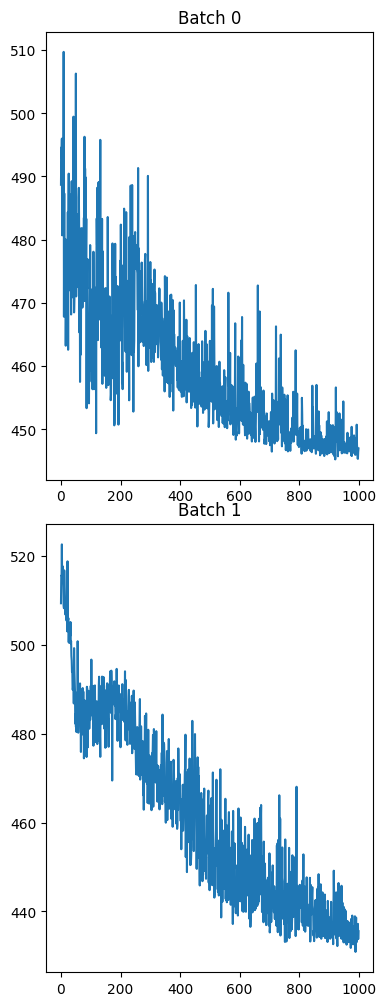

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 3.5064e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -1.1193e-04,  8.9730e-01],
         [ 5.5718e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           6.3727e-04, -2.0532e-02],
         [ 6.0319e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -4.8610e-03,  2.0497e-03],
         ...,
         [ 5.5527e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.2429e-02,  3.6450e-20],
         [ 5.8505e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -5.5417e-03, -6.3266e-21],
         [ 3.1307e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           9.6863e-04,  1.1062e-21]],

        [[ 6.0429e-02,  0.0000e+00, -7.7462e-04,  ...,  2.2719e-06,
          -1.4615e-05, -7.3924e-13],
         [ 6.5887e-02,  0.0000e+00,  2.6005e-02,  ..., -7.5411e-05,
           4.8510e-04,  2.4537e-11],
         [ 6.4772e-02,  0.0000e+00,  9.2591e-01,  ..., -3.9139e-04,
           2.5197e-03,  1.2735e-10],
         ...,
         [ 9.0016e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



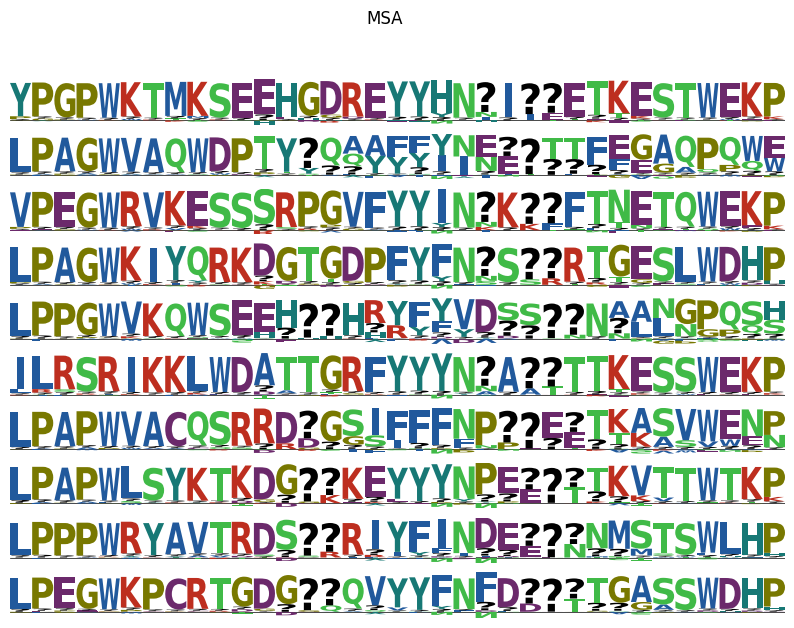

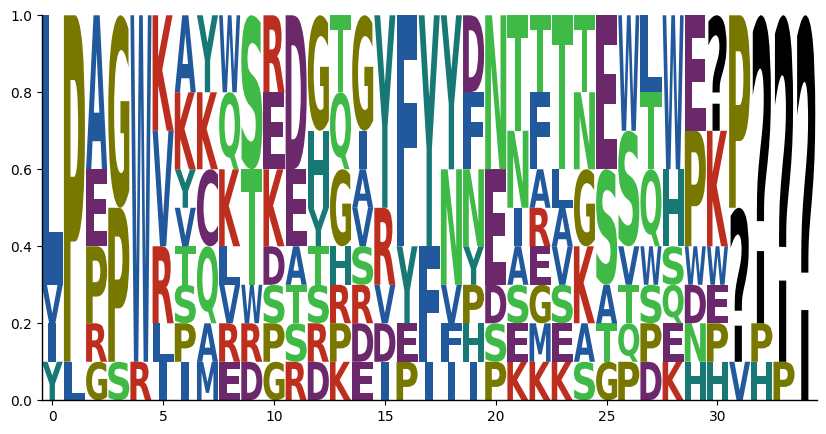

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



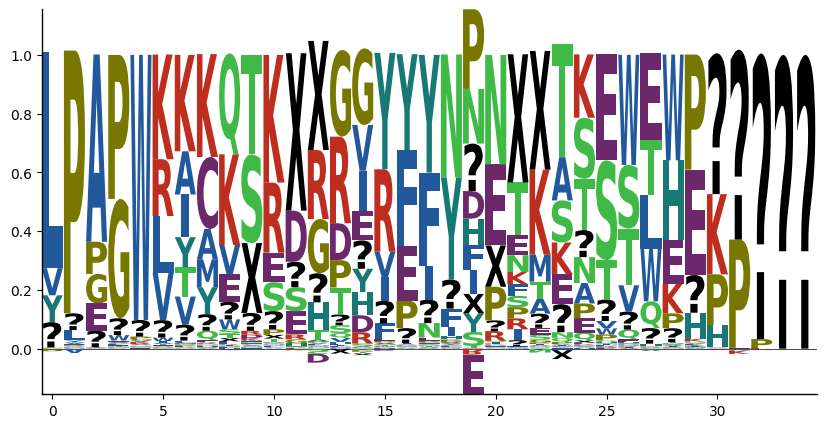

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



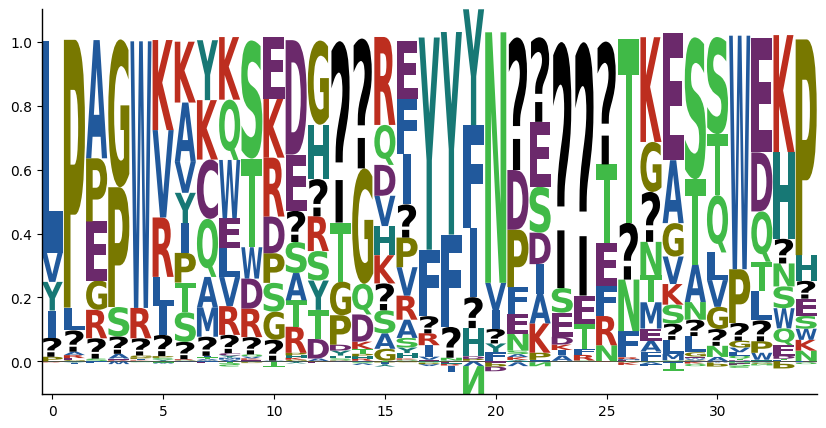

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



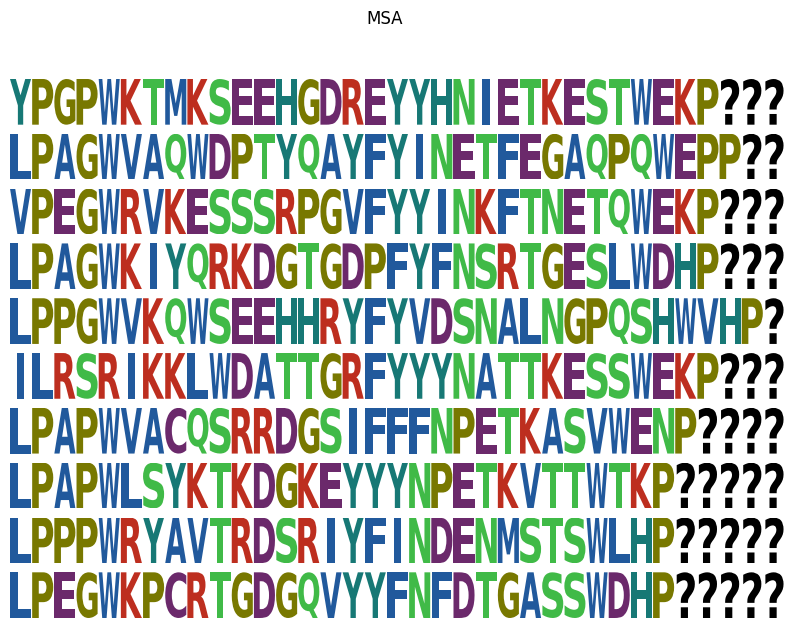

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):


    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq)
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq.to('cpu'), dataset_msa.prot_space.detach().cpu())



RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()